In [1]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve

import warnings
warnings.filterwarnings("ignore")

# Probability Calibration

When performing classification, we may want to predict the class label, and also to obtain a probability, certainty or confidence around the respective label, therefore to convey likelihood, we need calibrated probabilities.

Calibration is the concordance of predicted probabilities with the occurence of positive cases, for example, if 10 observations obtain a probability of 0.8 and the probability is calibrated, we can expect around 8 of those to belong to the positive class. The idea is to create buckets of probability predictions (like 0%, 20%, etc.).

If the probabilty is calibrated, we should see a match between the number of positive cases and the predicted probability.

Logistic Regression returns calibrated probabilities by design but some do not, like Decision Trees or Naive Bayes that return uncalibrated probabilities, by pushing probability mass away from 0 and 1 yielding sigmoid shape distortion in the predicted probabilities, and some models do not support probability prediction beause they output the class with no probability (like SVM for instance).

# Probability Calibration Curves

Xaxis: Predicted probabilities, in bins or intervals
Yaxis: Fraction of positive observations

The proximity to the red line (the perfect calibration) is important, and the number of observations per interval is important because it is harder to obtain the real positive fraction if we have few observations.

The probability Calibration Curve is relevant for both balanced and imbalanced datasets.

Too few bins may look well fit but might not be the case, and if we have too many bins it may look noisy!

With imbalanced datasets, it is very hard to say if the probability is calibrated, because there are few observations of the positive class, except if we increase the size of the dataset.

## Balanced Dataset

In [2]:
def create_dataset(weights,n_samples=10000):
    X, y = make_classification(n_samples=n_samples,
                               n_features=10,
                               n_redundant=0,
                               n_classes=2,
                               n_clusters_per_class=1,
                               weights=[weights],
                               class_sep=1.0,
                               shuffle=True,
                               random_state=24,
                               )
    
    X = pd.DataFrame(X)
    y = pd.Series(y)
    
    return X,y

In [3]:
X,y = create_dataset(weights=0.5)

In [4]:
X.head()

,0,1,2,3,4,5,6,7,8,9
0,0.369782,-1.341905,0.996886,-0.162134,-0.119393,1.014329,0.753164,-0.813546,-1.080355,-0.779129
1,-1.575108,-0.483887,2.029051,-0.217932,-0.094837,1.283099,-0.636313,1.193505,-0.101251,-0.112010
2,1.652587,-1.670416,2.011839,-0.091579,0.981247,1.038144,0.644532,-0.463789,1.134997,-0.879859
3,1.844499,-0.958619,1.132469,0.171479,0.222171,-1.067844,-1.482514,0.905279,-1.665921,-0.581644
4,-0.437962,-1.609034,1.772714,1.783558,-0.248718,1.749153,-0.298768,-0.828082,0.051507,1.915114


In [5]:
y.value_counts(normalize=True) * 100 #Balacing ratio

0    50.0
1    50.0
dtype: float64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=24)

In [7]:
y_train.value_counts(normalize=True) * 100 #Balacing ratio

0    50.179104
1    49.820896
dtype: float64

In [8]:
lr = LogisticRegression(penalty='l2',
                        C=1.0,
                        random_state=24,
                        solver='newton-cg',
                        max_iter=100,
                        n_jobs=-1,
                        )
lr.fit(X_train,y_train)

LogisticRegression(n_jobs=-1, random_state=24, solver='newton-cg')

In [9]:
probs = lr.predict_proba(X_test)[:,1]

In [10]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_test,
                                                                probs,
                                                                normalize=False,
                                                                n_bins=10,
                                                                strategy='uniform',
                                                                )

In [11]:
len(mean_predicted_value),len(fraction_of_positives)

(10, 10)

In [12]:
mean_predicted_value

array([0.02569626, 0.14495939, 0.24380369, 0.3477428 , 0.45131671,
       0.55032896, 0.65188179, 0.75188125, 0.8575362 , 0.97015078])

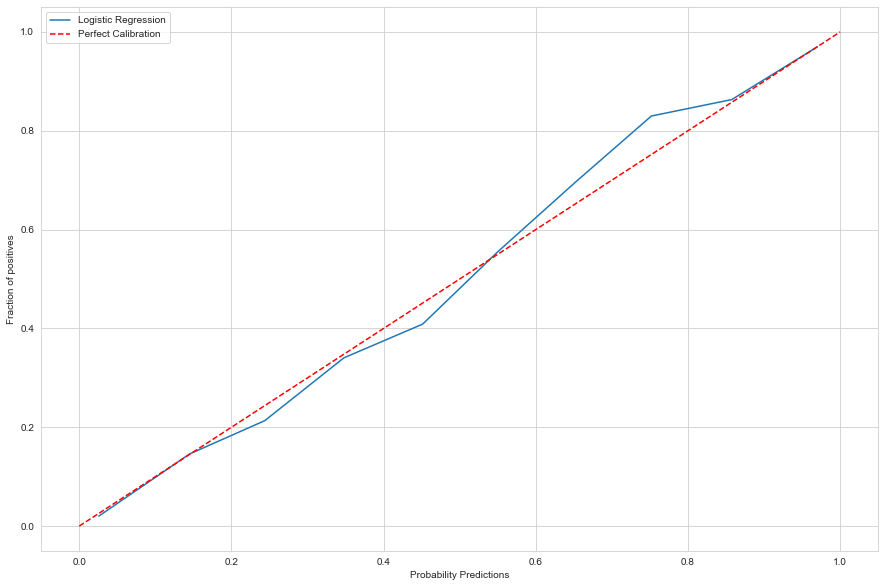

In [13]:
plt.figure(figsize=(15,10))
plt.plot(mean_predicted_value, fraction_of_positives,
         label="Logistic Regression")
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10),
         linestyle="--", color="red", label="Perfect Calibration")

plt.xlabel("Probability Predictions")
plt.ylabel("Fraction of positives")
plt.legend(loc="upper left")
plt.show()

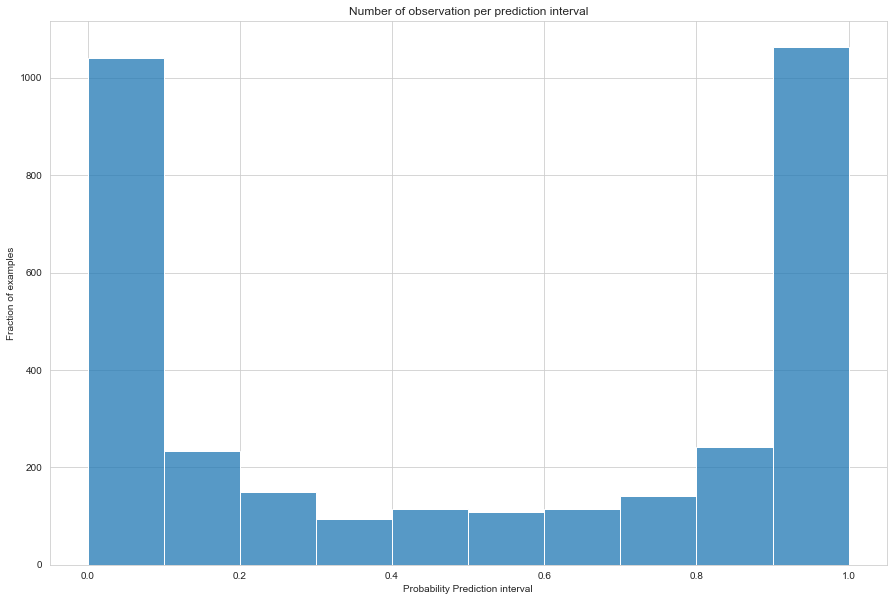

In [14]:
plt.figure(figsize=(15, 10))
sns.histplot(x=probs, bins=10)
plt.title("Number of observation per prediction interval")
plt.xlabel("Probability Prediction interval")
plt.ylabel("Fraction of examples")
plt.show()

In [15]:
def plot_calibration_curve(y_true, probs, bins, strategy):
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test,
                                                                    probs,
                                                                    normalize=False,
                                                                    n_bins=bins,
                                                                    strategy=strategy,
                                                                    )
    max_val = max(mean_predicted_value)

    plt.figure(figsize=(15, 10))
    plt.plot(mean_predicted_value, fraction_of_positives,
             label="Logistic Regression")
    plt.plot(np.linspace(0, max_val, bins), np.linspace(0, max_val, bins),
             linestyle="--", color="red", label="Perfect Calibration")

    plt.xlabel("Probability Predictions")
    plt.ylabel("Fraction of positives")
    plt.legend(loc="upper left")
    plt.show()


    plt.figure(figsize=(15, 10))

    sns.histplot(x=probs, bins=bins)
    plt.title("Number of observation per prediction interval")
    plt.xlabel("Probability Prediction interval")
    plt.ylabel("Fraction of examples")
    plt.show()

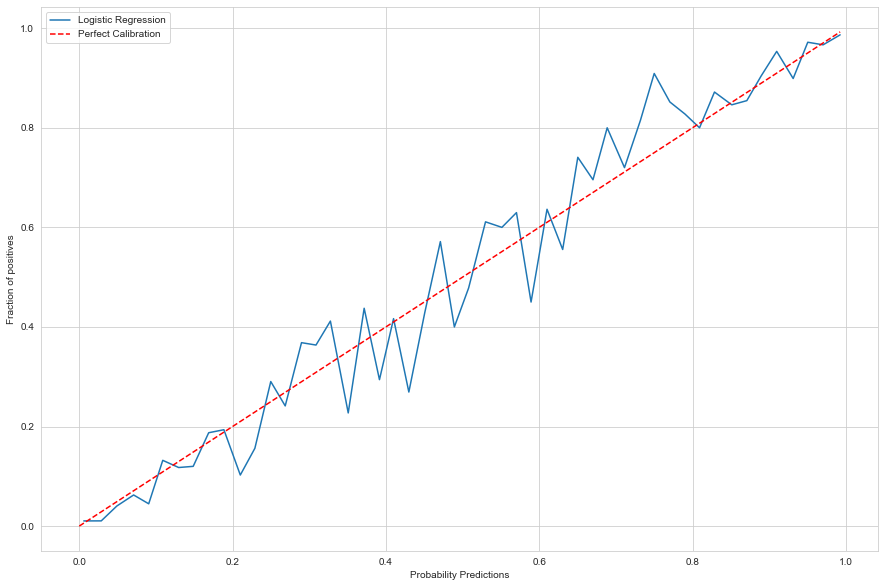

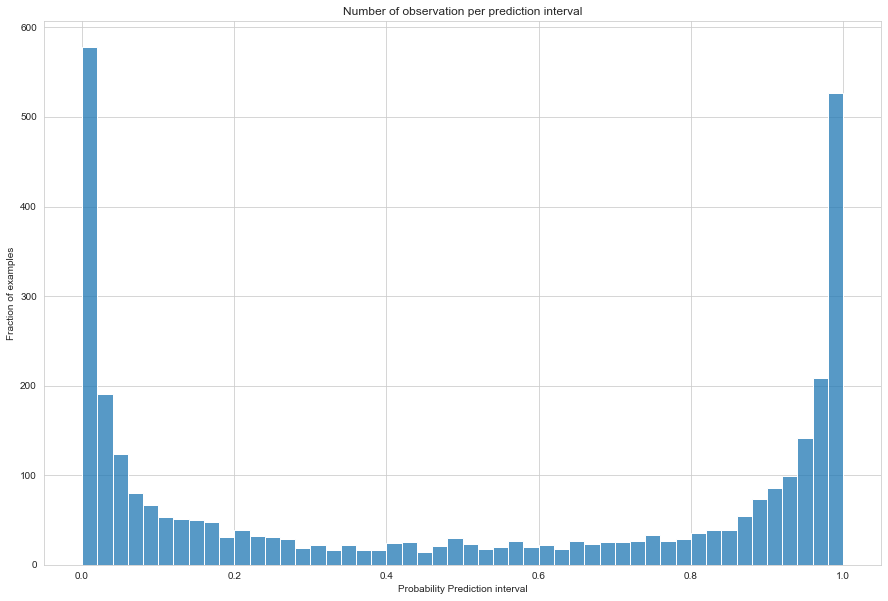

In [16]:
plot_calibration_curve(y_test, probs,bins=50,strategy="uniform")

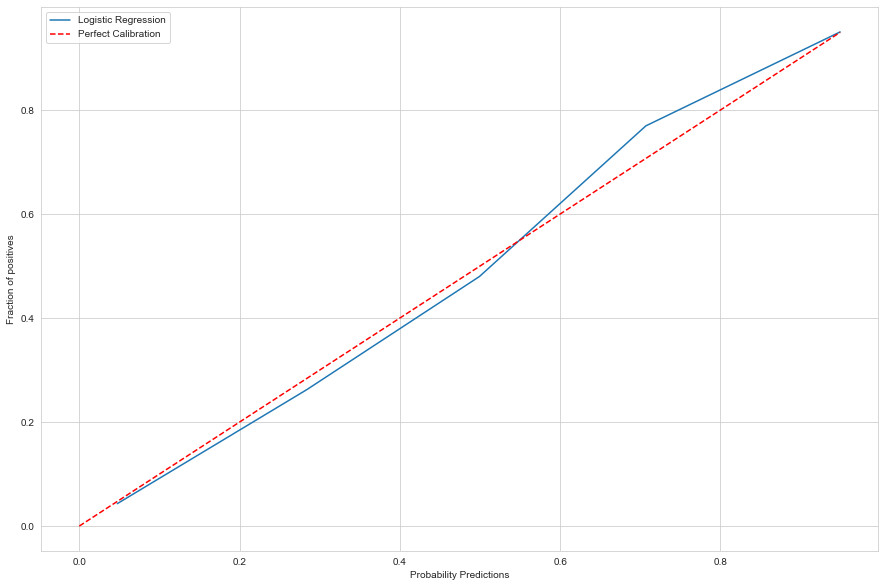

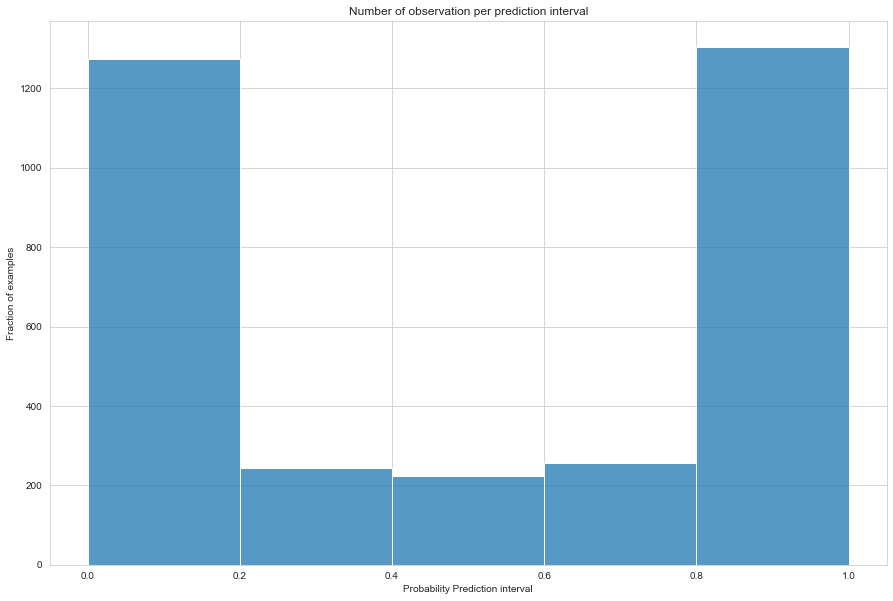

In [17]:
plot_calibration_curve(y_test, probs,bins=5,strategy="uniform")

## Imbalanced Dataset

In [18]:
X,y = create_dataset(weights=0.9)

In [19]:
y.value_counts(normalize=True) * 100 #Balacing ratio

0    89.62
1    10.38
dtype: float64

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=24)

In [21]:
y_train.value_counts(normalize=True) * 100 #Balacing ratio

0    89.567164
1    10.432836
dtype: float64

In [22]:
lr = LogisticRegression(penalty='l2',
                        C=1.0,
                        random_state=24,
                        solver='newton-cg',
                        max_iter=100,
                        n_jobs=-1,
                        )
lr.fit(X_train,y_train)
probs = lr.predict_proba(X_test)[:,1]

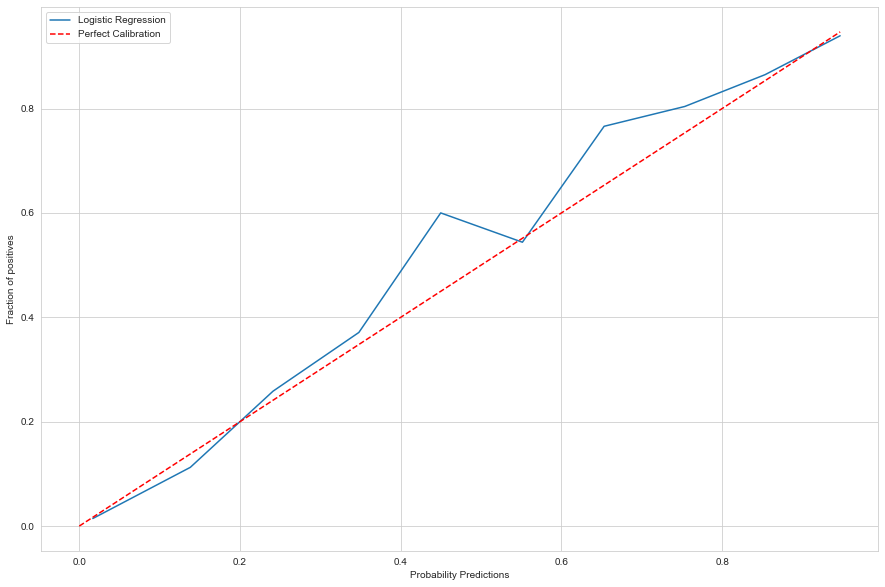

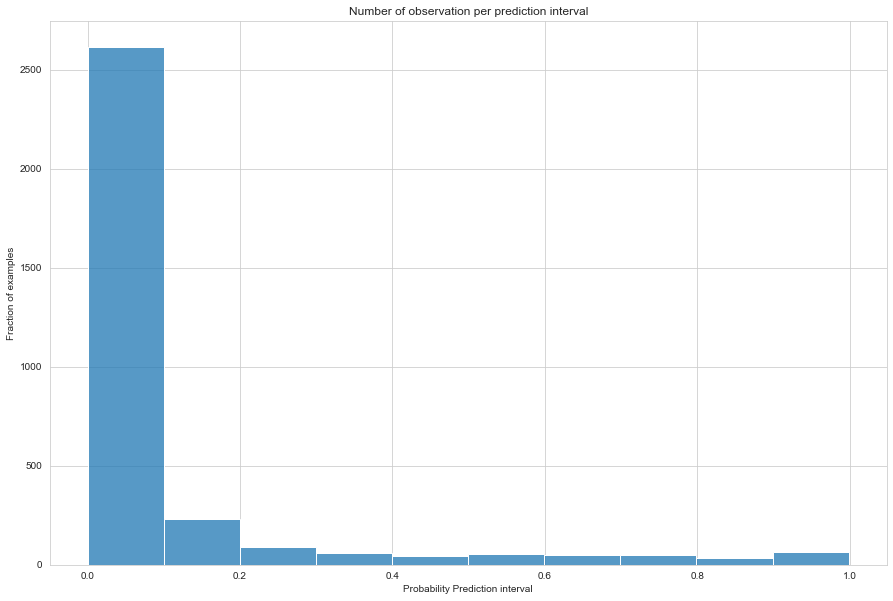

In [23]:
plot_calibration_curve(y_test, probs,bins=10,strategy="uniform")

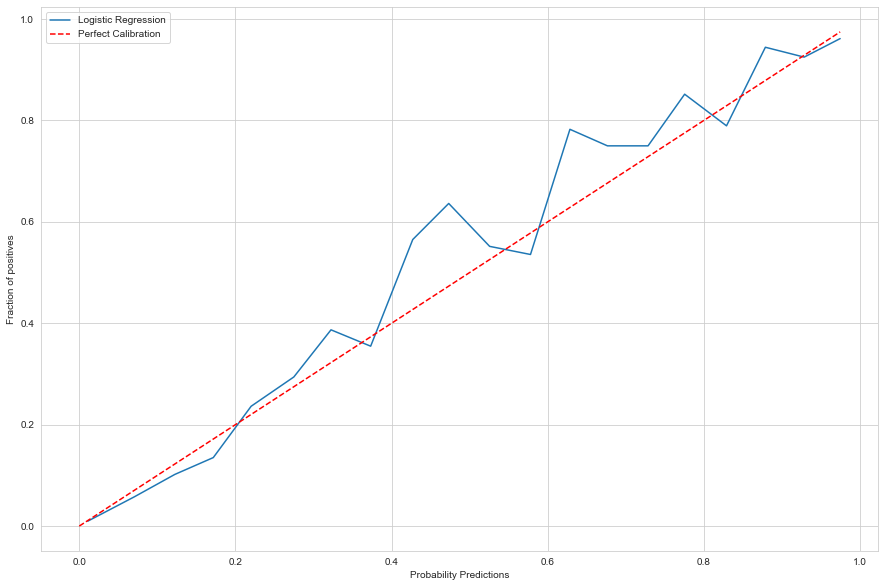

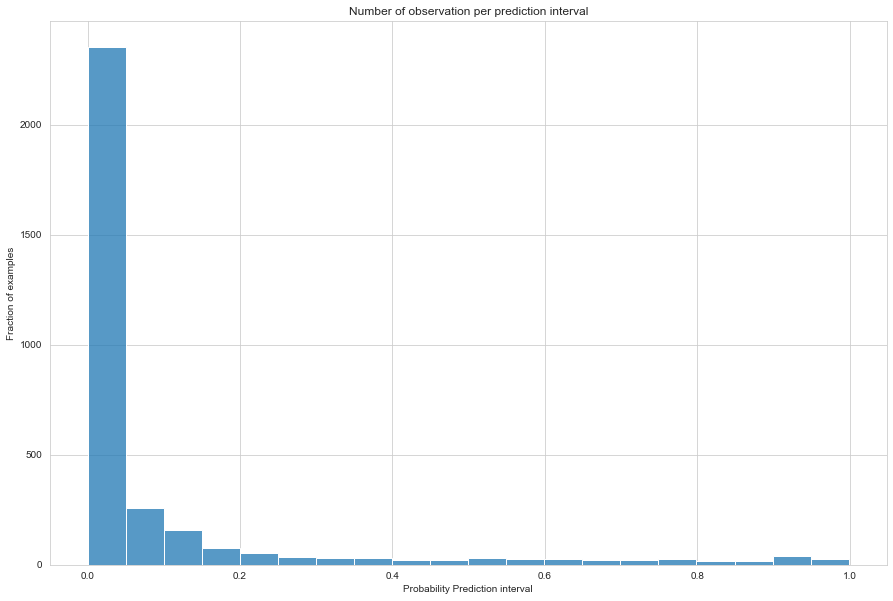

In [24]:
plot_calibration_curve(y_test, probs,bins=20,strategy="uniform")

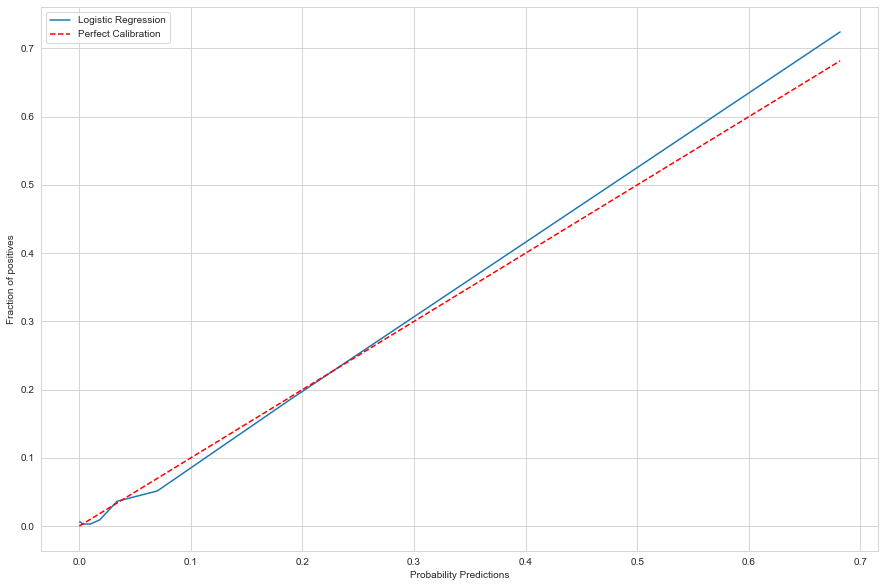

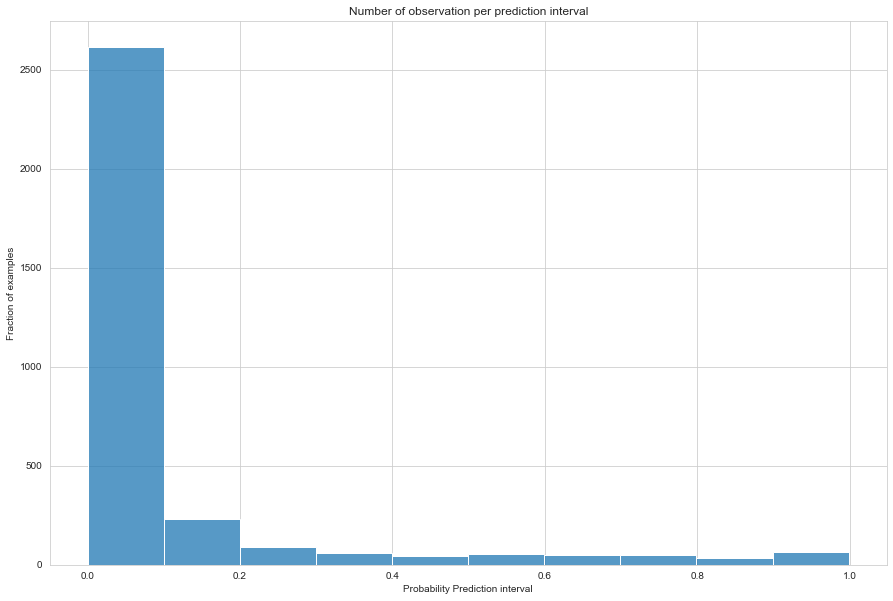

In [25]:
plot_calibration_curve(y_test, probs,bins=10,strategy="quantile")

In [26]:
X,y = create_dataset(n_samples=10000, weights=0.9)

In [27]:
y.value_counts(normalize=True) * 100 #Balacing ratio

0    89.62
1    10.38
dtype: float64

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=24)

In [29]:
y_train.value_counts(normalize=True) * 100 #Balacing ratio

0    89.567164
1    10.432836
dtype: float64

In [30]:
lr = LogisticRegression(penalty='l2',
                        C=1.0,
                        random_state=24,
                        solver='newton-cg',
                        max_iter=100,
                        n_jobs=-1,
                        )
lr.fit(X_train,y_train)
probs = lr.predict_proba(X_test)[:,1]

In [31]:
len(probs),len(y_test)

(3300, 3300)

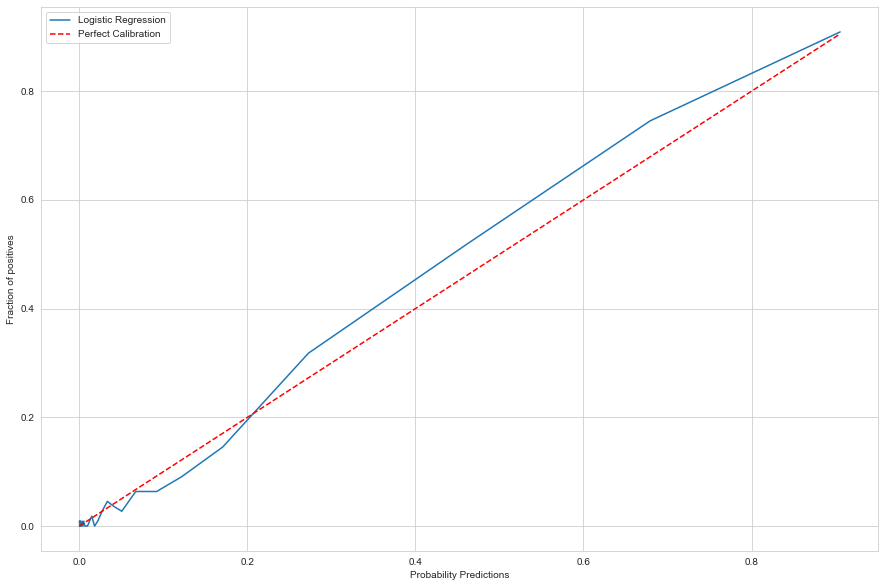

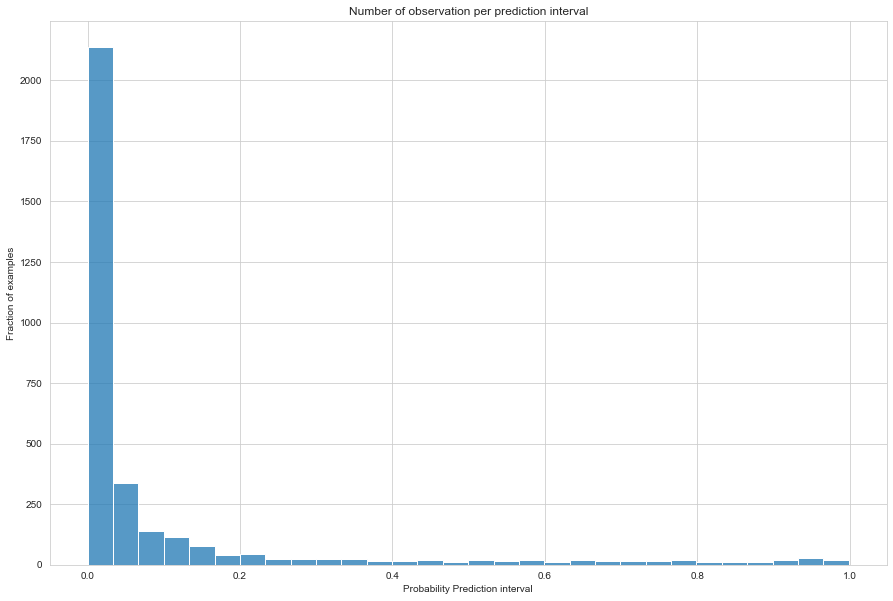

In [32]:
plot_calibration_curve(y_test, probs,bins=30,strategy="quantile")

Classes are perfectly separable, hence the two buckets only...

# Brier Score

The brier score is a metric that measures the accuracy of probabilistic estimates of the data, and the formula is the average square difference of the observed label vs the predicted probability.

BS = sum((y - pred)^2) / n

The Brier Score is small when the probabilistic estimates are close to the real class, and it increases as they diverge. It varies between 0 and 1, and tends to work well with balanced data but not that much with imbalanced data because the effect of the rare observations does not affect the overall score.

In [33]:
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (roc_auc_score,
                             brier_score_loss,
                             plot_roc_curve
                            )

## Balanced Dataset

In [34]:
X,y = create_dataset(weights=0.5)

In [35]:
y.value_counts(normalize=True) #balacing ratio

0    0.5
1    0.5
dtype: float64

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=24)

In [37]:
y_train.value_counts(normalize=True) #balacing ratio

0    0.501791
1    0.498209
dtype: float64

In [38]:
lr = LogisticRegression(penalty='l2',
                        C=1.0,
                        random_state=24,
                        solver='newton-cg',
                        max_iter=100,
                        n_jobs=-1,
                        ).fit(X_train, y_train)

bayes = GaussianNB().fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=10,
                            n_jobs=-1,
                            random_state=24,
                            ).fit(X_train, y_train)

gbc = GradientBoostingClassifier(n_estimators=10,
                            random_state=24,
                            ).fit(X_train, y_train)

In [39]:
for model in [lr,bayes,rf,gbc]:
    probs = model.predict_proba(X_test)[:,1]
    print(f"roc-auc of {type(model).__name__}: {roc_auc_score(y_test,probs)}.")

roc-auc of LogisticRegression: 0.9593829756284631.
roc-auc of GaussianNB: 0.9608115176707235.
roc-auc of RandomForestClassifier: 0.9420900499420355.
roc-auc of GradientBoostingClassifier: 0.9591581703495062.


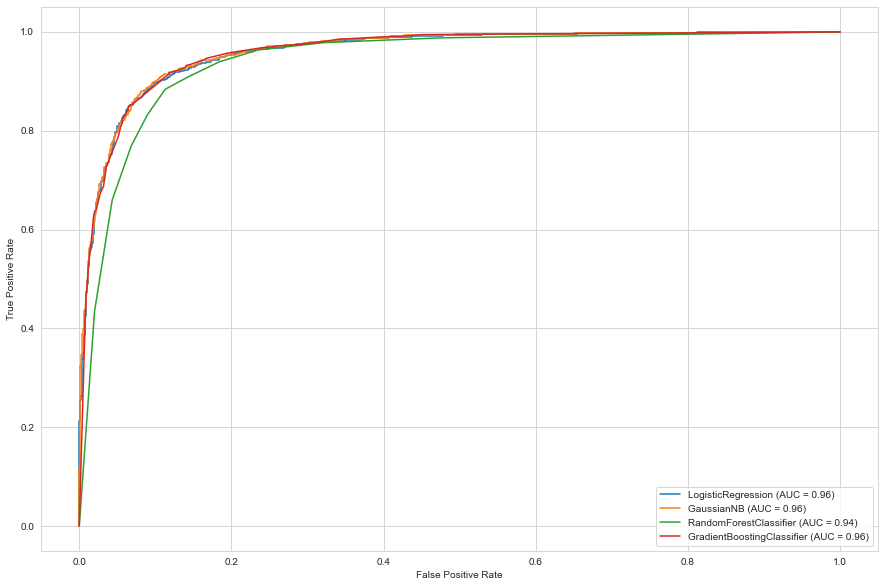

In [40]:
plt.figure(figsize=(15,10))
ax = plt.gca()


for model in [lr,bayes,rf,gbc]:
    tmp_disp = plot_roc_curve(model,X_test,y_test,ax=ax)

In [41]:
for model in [lr,bayes,rf,gbc]:
    probs = model.predict_proba(X_test)[:,1]
    print(f"Brier Score of {type(model).__name__}: {brier_score_loss(y_test,probs)}.")

Brier Score of LogisticRegression: 0.07693352805022269.
Brier Score of GaussianNB: 0.07566250710289886.
Brier Score of RandomForestClassifier: 0.08810000000000001.
Brier Score of GradientBoostingClassifier: 0.09862815950375417.


In [42]:
def plot_calibration_curve(bins, strategy):
    plt.figure(figsize=(15, 10))

    for model in [lr,bayes,rf,gbc]:
        probs = model.predict_proba(X_test)[:,1]
    
        fraction_of_positives, mean_predicted_value = calibration_curve(y_test,
                                                                    probs,
                                                                    normalize=False,
                                                                    n_bins=bins,
                                                                    strategy=strategy,
                                                                    )
        max_val = max(mean_predicted_value)

        plt.plot(mean_predicted_value, fraction_of_positives,
             label=type(model).__name__)
    plt.plot(np.linspace(0, max_val, bins), np.linspace(0, max_val, bins),
             linestyle="--", color="red", label="Perfect Calibration")

    plt.xlabel("Probability Predictions")
    plt.ylabel("Fraction of positives")
    plt.legend(loc="upper left")
    plt.show()

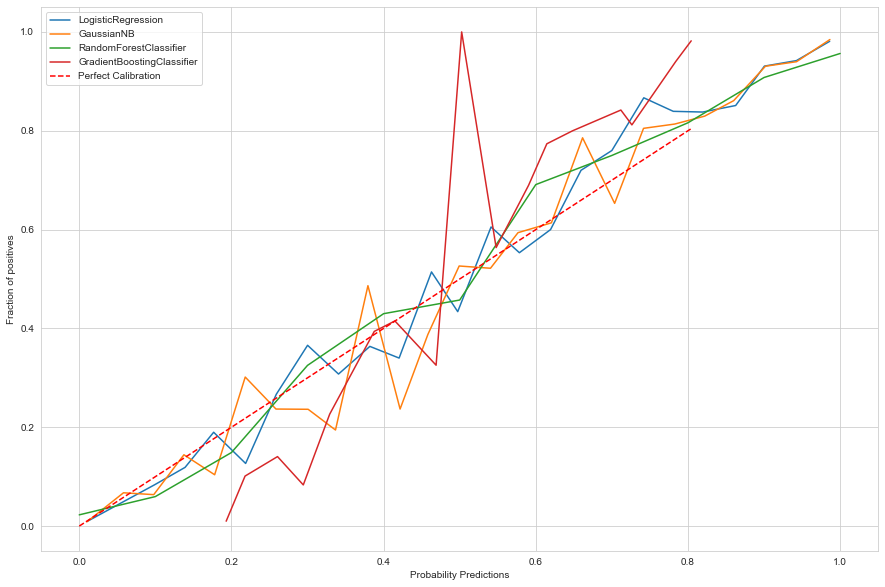

In [43]:
plot_calibration_curve(bins=25,strategy="uniform")

## Imbalanced Dataset

In [44]:
X,y = create_dataset(weights=0.9)

In [45]:
y.value_counts(normalize=True) #balacing ratio

0    0.8962
1    0.1038
dtype: float64

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=24)

In [47]:
y_train.value_counts(normalize=True) #balacing ratio

0    0.895672
1    0.104328
dtype: float64

In [48]:
lr = LogisticRegression(penalty='l2',
                        C=1.0,
                        random_state=24,
                        solver='newton-cg',
                        max_iter=100,
                        n_jobs=-1,
                        ).fit(X_train, y_train)

bayes = GaussianNB().fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=10,
                            n_jobs=-1,
                            random_state=24,
                            ).fit(X_train, y_train)

gbc = GradientBoostingClassifier(n_estimators=10,
                            random_state=24,
                            ).fit(X_train, y_train)

In [49]:
for model in [lr,bayes,rf,gbc]:
    probs = model.predict_proba(X_test)[:,1]
    print(f"roc-auc of {type(model).__name__}: {roc_auc_score(y_test,probs)}.")

roc-auc of LogisticRegression: 0.9457549918856641.
roc-auc of GaussianNB: 0.9489329822600393.
roc-auc of RandomForestClassifier: 0.9066378156944905.
roc-auc of GradientBoostingClassifier: 0.934480597820835.


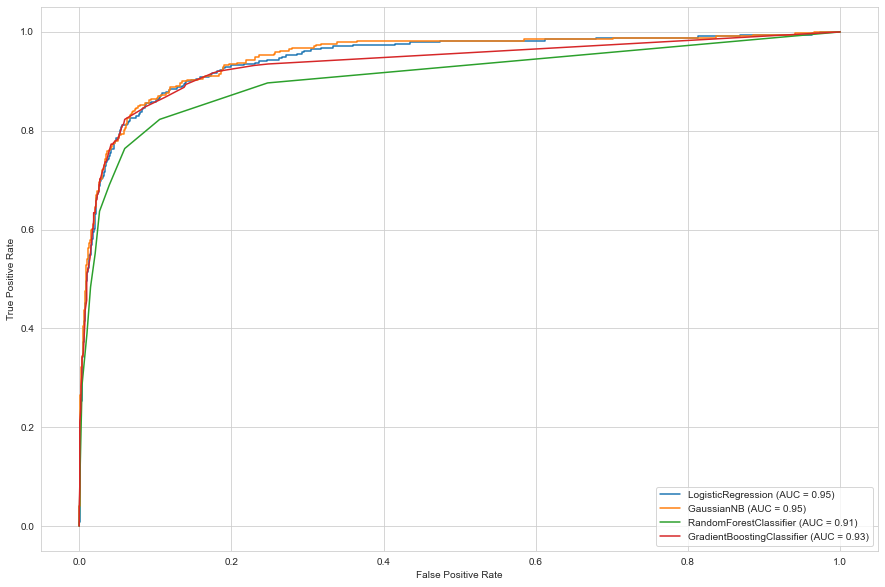

In [50]:
plt.figure(figsize=(15,10))
ax = plt.gca()


for model in [lr,bayes,rf,gbc]:
    tmp_disp = plot_roc_curve(model,X_test,y_test,ax=ax)

In [51]:
for model in [lr,bayes,rf,gbc]:
    probs = model.predict_proba(X_test)[:,1]
    print(f"Brier Score of {type(model).__name__}: {brier_score_loss(y_test,probs)}.")

Brier Score of LogisticRegression: 0.04311124542018152.
Brier Score of GaussianNB: 0.04189798600759055.
Brier Score of RandomForestClassifier: 0.049415151515151516.
Brier Score of GradientBoostingClassifier: 0.048341954180130244.


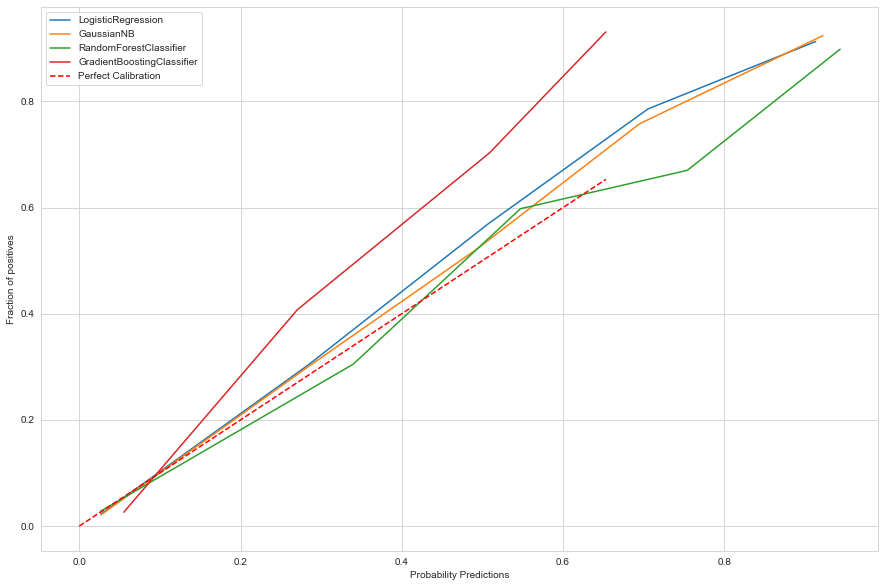

In [52]:
plot_calibration_curve(bins=5,strategy="uniform")

# Re-Sampling and Cost-Sensitive Learning on Probability Calibration

Over-Sampling, Under-Sampling and Cost-Sensitive Learning distort the relationship between the returned probabilities and the fraction of positive observations.

The firsts distort the distribution of classes and the second modifies the learning function.

Probabilities can be much more informative than labels therefore to convey likelihood, we need to calibrate the probabilities after re-sampling or cost-sensitive learning.

# Calibrating a Classifier

Calibrating a classifier means mapping model predictions to posterior probabilities.

fcalib is a calibration function
s(x) is the score returned by a model, probability or the decision function (eg SVMs)
p(y) is the posterior probability

--> fcalib(s(x)) ~ p(y)

Two common ways:
* Plat Scaling
    * Trains a logistic regression to regress the classifier score to real likelihood (fraction of positives)
    * Fplatt= 1 / 1 + exp^(-ws(x)-b) 
* Isotonic Regression
    * fcalib can be any function as long as the function is monotonic.
    * Learns arbitrary monotonically increasing step functions.
    * Groups data into constant parts, steps
    * Minimises the estimation of y respect of y

To get good posterior probabilities, we should not calibrate our classifiers on the training set (because of over-fitting), so it should be done on the test set, and when possible keep mre than 1 hold out sample.

If little data, then we can do cross-validation.

In [53]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [54]:
X, y = create_dataset(weights=0.5, n_samples=100000)

In [55]:
y.value_counts(normalize=True) #balacing ratio

1    0.50021
0    0.49979
dtype: float64

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=24)

In [57]:
y_train.value_counts(normalize=True) #balacing ratio

0    0.500657
1    0.499343
dtype: float64

In [58]:
rf = RandomForestClassifier(
    n_estimators=100, random_state=24, max_depth=2).fit(X_train, y_train)

In [59]:
probs = rf.predict_proba(X_test)[:,1]

In [60]:
print(f"Roc-auc on train set: {roc_auc_score(y_train,rf.predict_proba(X_train)[:,1])}")
print(f"Roc-auc on test set: {roc_auc_score(y_test,probs)}")

Roc-auc on train set: 0.9949896888394185
Roc-auc on test set: 0.9942886404756878


In [61]:
print(f"Brier score on train set: {brier_score_loss(y_train,rf.predict_proba(X_train)[:,1])}")
print(f"Brier score on test set: {brier_score_loss(y_test,probs)}")

Brier score on train set: 0.10401175451266062
Brier score on test set: 0.10442643252493938


In [62]:
def plot_calibration_curve(y_true, probs, bins, strategy):
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test,
                                                                    probs,
                                                                    normalize=False,
                                                                    n_bins=bins,
                                                                    strategy=strategy,
                                                                    )
    max_val = max(mean_predicted_value)

    plt.figure(figsize=(15, 10))
    plt.plot(mean_predicted_value, fraction_of_positives,
             label="Logistic Regression")
    plt.plot(np.linspace(0, max_val, bins), np.linspace(0, max_val, bins),
             linestyle="--", color="red", label="Perfect Calibration")

    plt.xlabel("Probability Predictions")
    plt.ylabel("Fraction of positives")
    plt.legend(loc="upper left")
    plt.show()


    plt.figure(figsize=(15, 10))

    sns.histplot(x=probs, bins=bins)
    plt.title("Number of observation per prediction interval")
    plt.xlabel("Probability Prediction interval")
    plt.ylabel("Fraction of examples")
    plt.show()

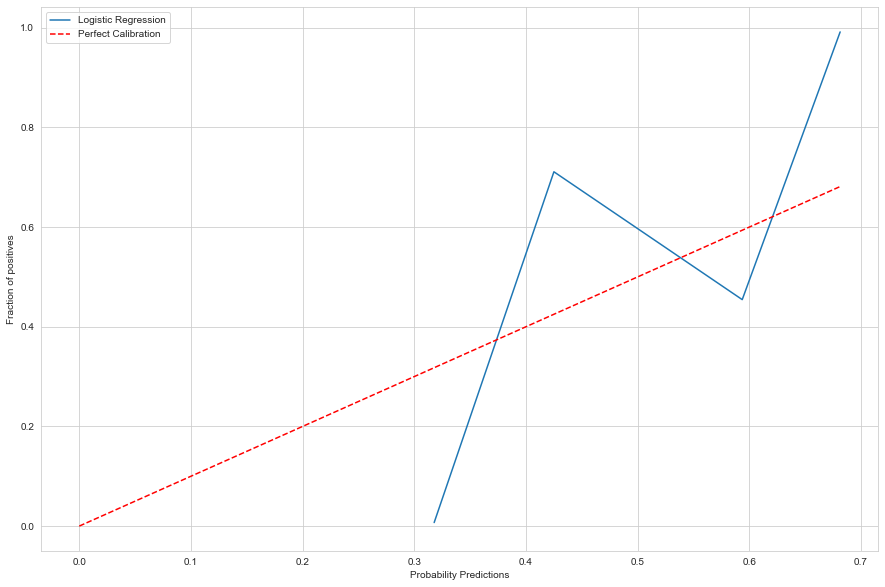

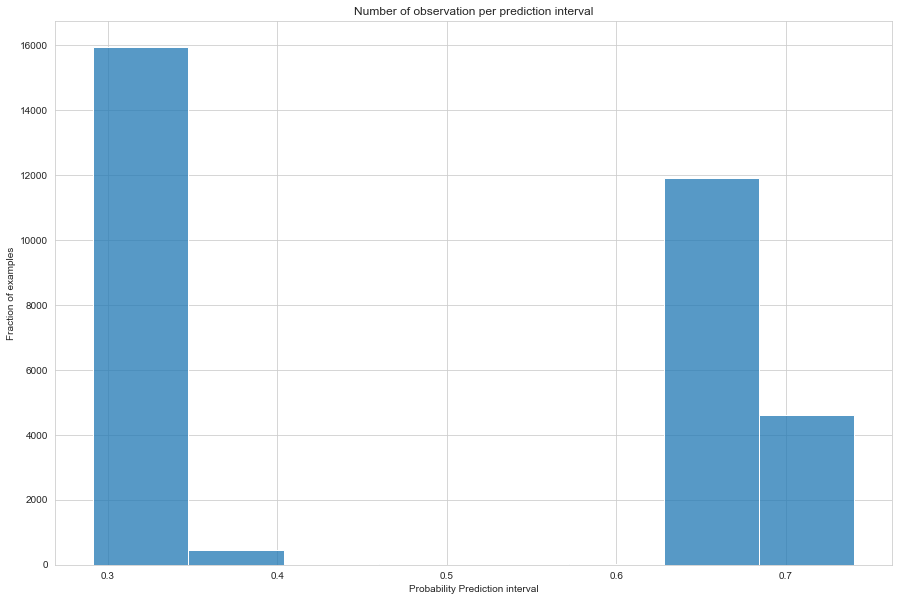

In [63]:
plot_calibration_curve(y_test,probs,bins=8, strategy="uniform")

In [64]:
# Isotonic calibration
clf_isotonic = CalibratedClassifierCV(rf,cv=5,method="isotonic")
clf_isotonic.fit(X_test,y_test)
prob_isotonic = clf_isotonic.predict_proba(X_test)[:,1]

# Sigmoid calibration
clf_isotonic = CalibratedClassifierCV(rf,cv=5,method="sigmoid")
clf_isotonic.fit(X_test,y_test)
sigmoid_isotonic = clf_isotonic.predict_proba(X_test)[:,1]

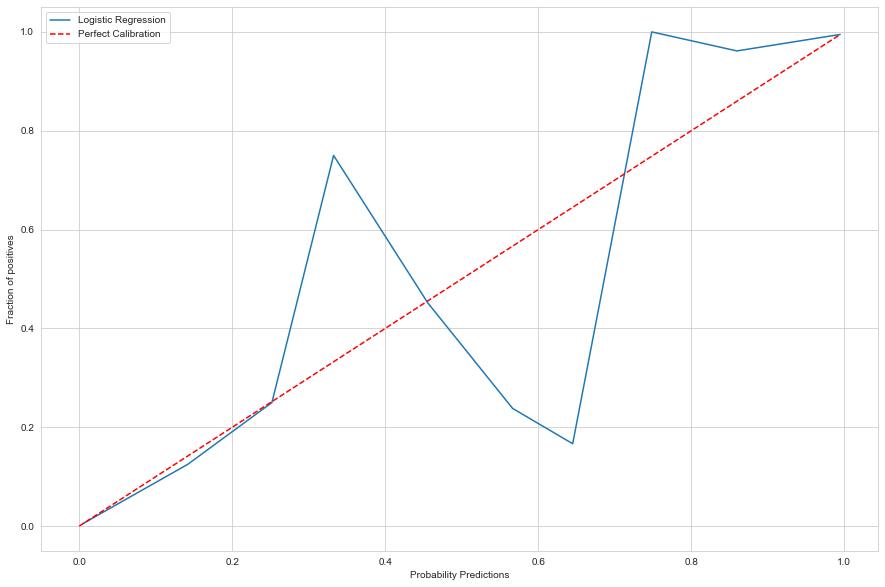

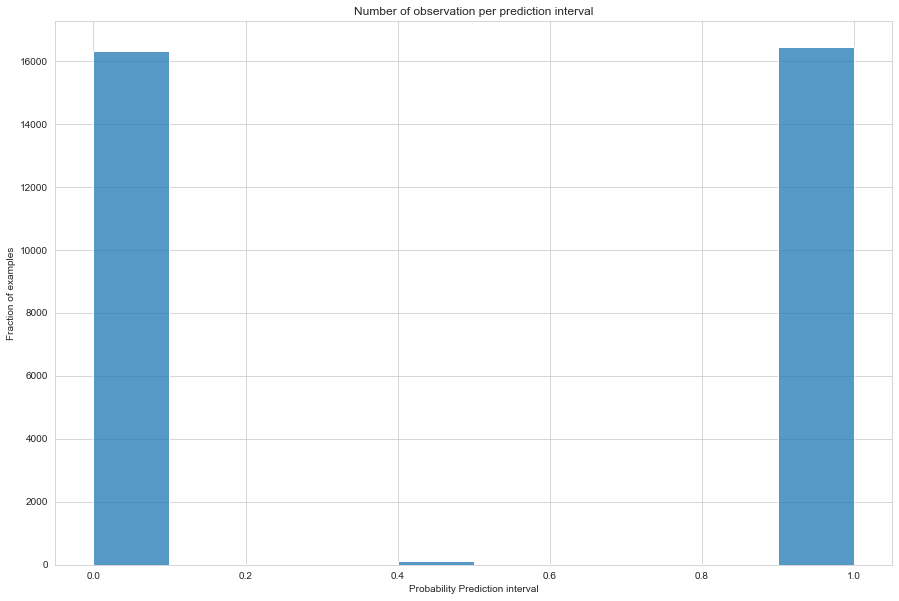

In [65]:
plot_calibration_curve(y_test,prob_isotonic,bins=10, strategy="uniform")

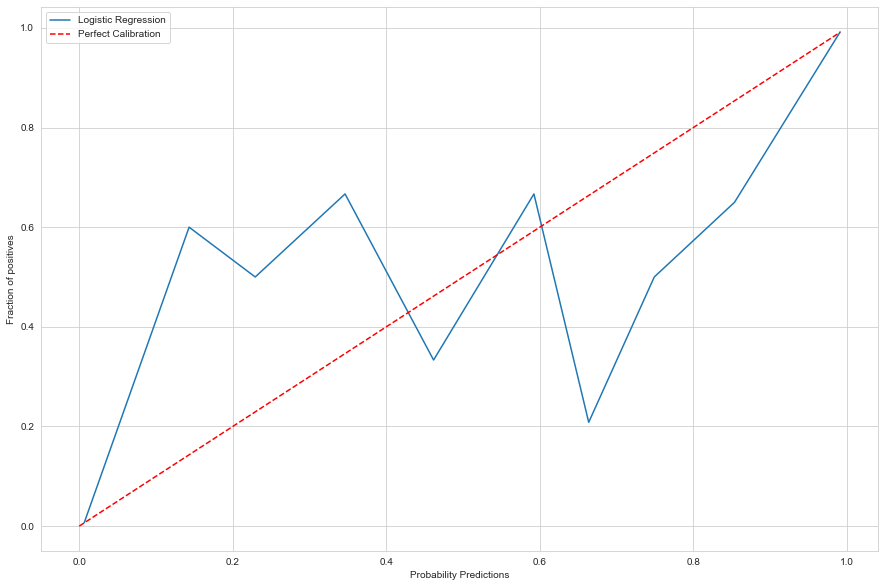

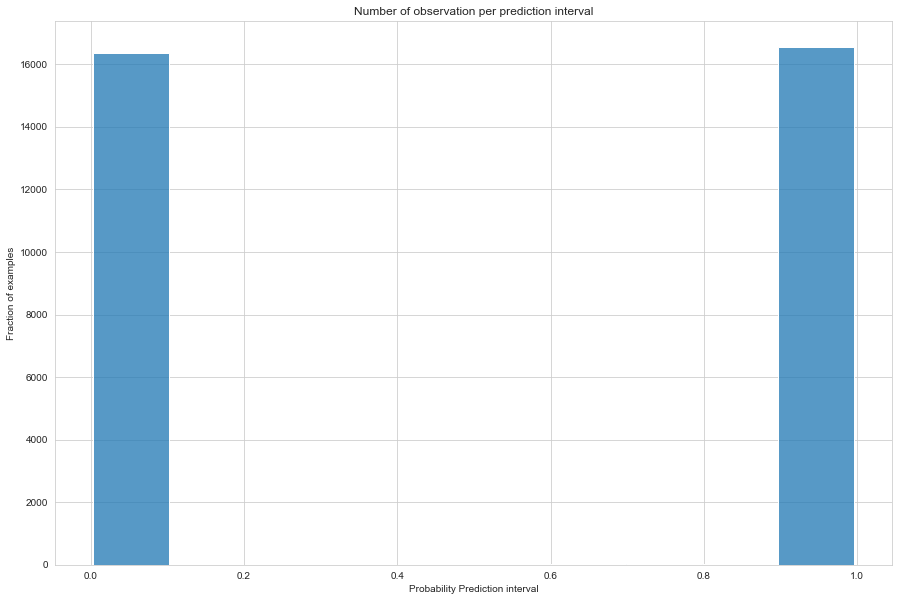

In [66]:
plot_calibration_curve(y_test,sigmoid_isotonic,bins=10, strategy="uniform")

In [67]:
from sklearn.datasets import load_breast_cancer

In [68]:
X, y = load_breast_cancer(return_X_y=True)

In [69]:
pd.Series(y).value_counts(normalize=True) #balacing ratio

1    0.627417
0    0.372583
dtype: float64

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=24)

In [71]:
pd.Series(y_train).value_counts(normalize=True) #balacing ratio

1    0.635171
0    0.364829
dtype: float64

In [72]:
rf = RandomForestClassifier(
    n_estimators=100, random_state=24, max_depth=2).fit(X_train, y_train)

In [73]:
probs = rf.predict_proba(X_test)[:,1]

In [74]:
print(
    f"Roc-auc on train set: {roc_auc_score(y_train,rf.predict_proba(X_train)[:,1])}")
print(f"Roc-auc on test set: {roc_auc_score(y_test,probs)}")
print("\n")
print(
    f"Brier Score on train set: {brier_score_loss(y_train,rf.predict_proba(X_train)[:,1])}")
print(f"Brier Score on test set: {brier_score_loss(y_test,probs)}")

Roc-auc on train set: 0.9941435281526845
Roc-auc on test set: 0.9864800476474092


Brier Score on train set: 0.03304978661506511
Brier Score on test set: 0.03937265460953883


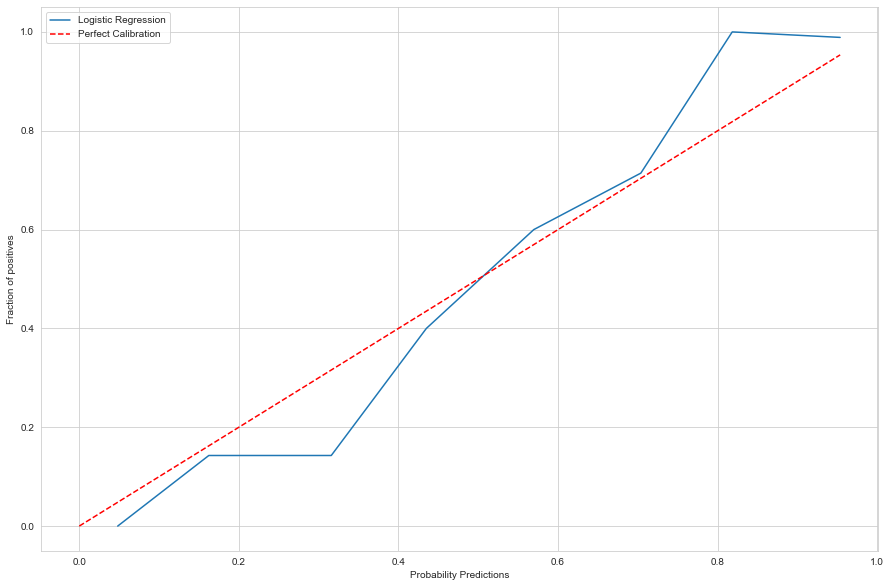

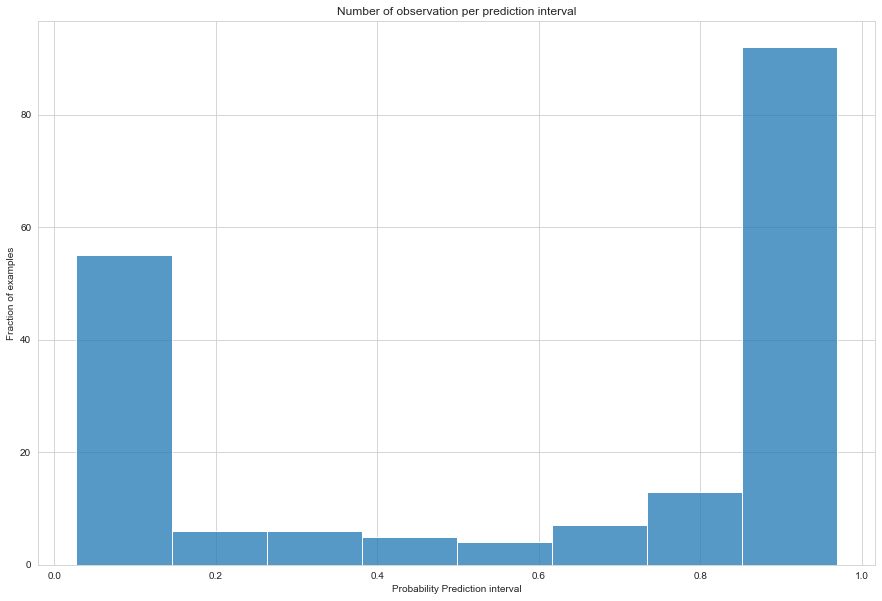

In [75]:
plot_calibration_curve(y_test, probs, bins=8, strategy="uniform")

In [76]:
# Isotonic calibration
clf_isotonic = CalibratedClassifierCV(rf,cv=5,method="isotonic")
clf_isotonic.fit(X_test,y_test)
prob_isotonic = clf_isotonic.predict_proba(X_test)[:,1]

# Sigmoid calibration
clf_isotonic = CalibratedClassifierCV(rf,cv=5,method="sigmoid")
clf_isotonic.fit(X_test,y_test)
sigmoid_isotonic = clf_isotonic.predict_proba(X_test)[:,1]

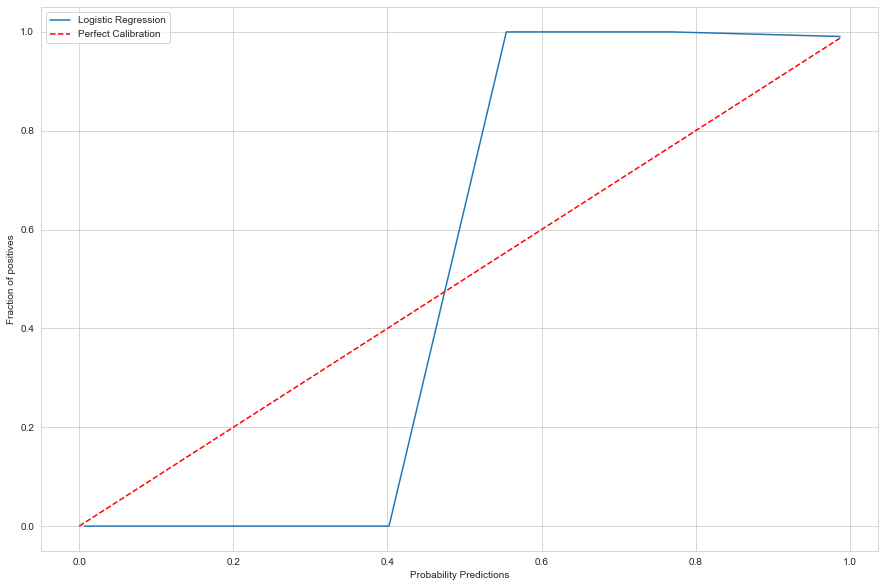

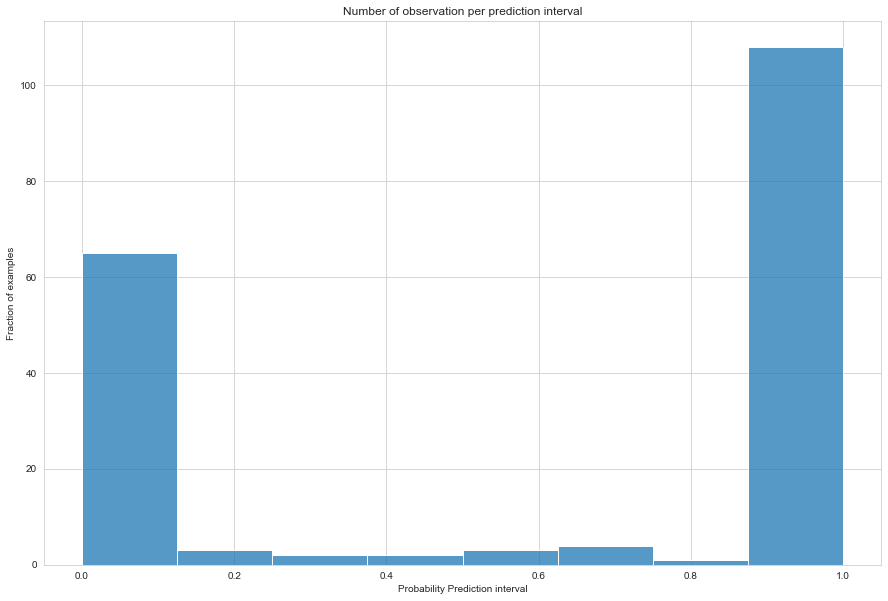

In [77]:
plot_calibration_curve(y_test, prob_isotonic, bins=8, strategy="uniform")

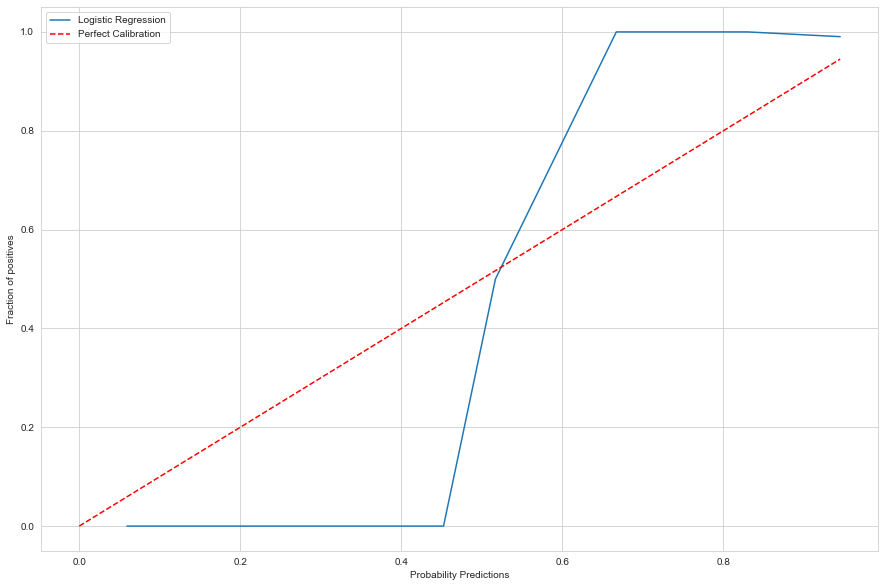

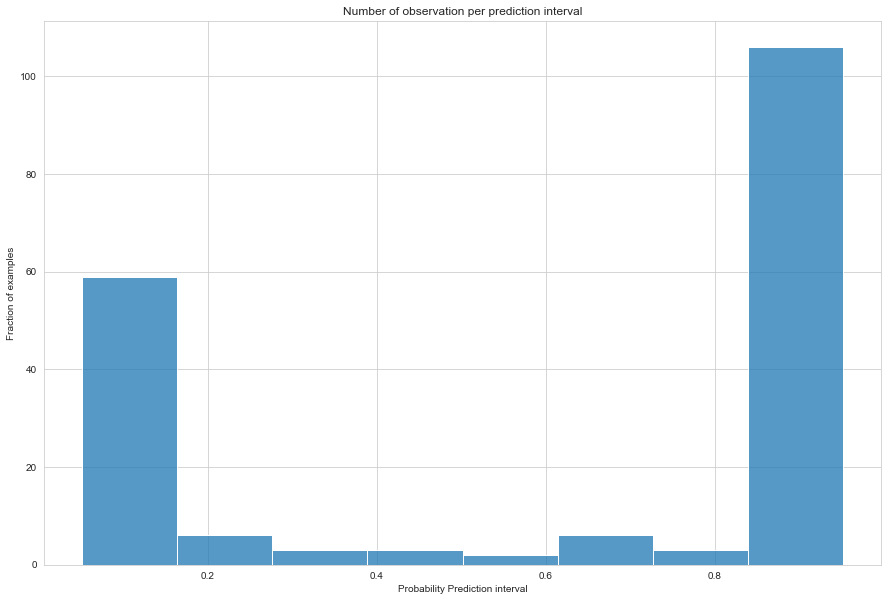

In [78]:
plot_calibration_curve(y_test, sigmoid_isotonic, bins=8, strategy="uniform")

# Calibrating a Classifier after SMOTE or Under-Sampling

In [79]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE

In [80]:
def load_data():
    
    df = pd.read_csv("./kdd2004.csv")
    df["target"] = df["target"].map({-1:0,1:1})
    
    return df

In [81]:
df = load_data()

In [82]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(
    labels=["target"], axis=1), df["target"], test_size=0.33, random_state=24)

In [83]:
y_train.value_counts(normalize=True)

0    0.991019
1    0.008981
Name: target, dtype: float64

In [84]:
rf =  RandomForestClassifier(n_estimators=100,
                            random_state=24,
                            max_depth=2,
                            n_jobs=-1)

lr = LogisticRegression(penalty="l2",
                       solver="newton-cg",
                       random_state=24,
                       max_iter=10,
                       n_jobs=-1)

In [85]:
rus = RandomUnderSampler(sampling_strategy='auto',
                         random_state=24,
                         replacement=True
                         )

X_rus, y_rus = rus.fit_resample(X_train, y_train)

sm_b1 = BorderlineSMOTE(sampling_strategy='auto',
                        random_state=24,
                        k_neighbors=5,
                        n_jobs=-1,
                        m_neighbors=10,
                        kind='borderline-1',
                        )

X_smb,y_smb = sm_b1.fit_resample(X_train,y_train)

In [86]:
y_rus.value_counts(normalize=True), y_smb.value_counts(normalize=True)

(0    0.5
 1    0.5
 Name: target, dtype: float64,
 0    0.5
 1    0.5
 Name: target, dtype: float64)

In [87]:
y_rus.value_counts(normalize=False), y_smb.value_counts(normalize=False)

(0    877
 1    877
 Name: target, dtype: int64,
 0    96776
 1    96776
 Name: target, dtype: int64)

In [88]:
for model in [rf, lr]:
    print("Baseline Model")
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:, 1]
    print(f"Roc-auc on test set for {type(model).__name__}: {roc_auc_score(y_test,probs)}")
    print(f"Brier Score on test set for {type(model).__name__}: {brier_score_loss(y_test,probs)}")
    print("\n")
    
    print("Undersampling")
    model.fit(X_rus, y_rus)
    probs = model.predict_proba(X_test)[:, 1]
    print(f"Roc-auc on test set for {type(model).__name__}: {roc_auc_score(y_test,probs)}")
    print(f"Brier Score on test set for {type(model).__name__}: {brier_score_loss(y_test,probs)}")
    print("\n")
    
    print("Oversampling with SMOTE")
    model.fit(X_smb,y_smb)
    probs = model.predict_proba(X_test)[:, 1]
    print(f"Roc-auc on test set for {type(model).__name__}: {roc_auc_score(y_test,probs)}")
    print(f"Brier Score on test set for {type(model).__name__}: {brier_score_loss(y_test,probs)}")
    print("\n")


Baseline Model
Roc-auc on test set for RandomForestClassifier: 0.9069101035209559
Brier Score on test set for RandomForestClassifier: 0.003564224849266845


Undersampling
Roc-auc on test set for RandomForestClassifier: 0.9788093115350113
Brier Score on test set for RandomForestClassifier: 0.049453115734327834


Oversampling with SMOTE
Roc-auc on test set for RandomForestClassifier: 0.9717603317852419
Brier Score on test set for RandomForestClassifier: 0.03866445217299514


Baseline Model
Roc-auc on test set for LogisticRegression: 0.9108892048109519
Brier Score on test set for LogisticRegression: 0.004266542429696788


Undersampling
Roc-auc on test set for LogisticRegression: 0.9727783019507796
Brier Score on test set for LogisticRegression: 0.05123929695558514


Oversampling with SMOTE
Roc-auc on test set for LogisticRegression: 0.9567483440496387
Brier Score on test set for LogisticRegression: 0.04147959499382138




In [89]:
lr.fit(X_train, y_train)
probs_lr = lr.predict_proba(X_test)[:, 1]

rf.fit(X_train, y_train)
probs_rf = rf.predict_proba(X_test)[:, 1]

In [90]:
def plot_calibration_curve(y_true, probs, bins, strategy,model):
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test,
                                                                    probs,
                                                                    normalize=False,
                                                                    n_bins=bins,
                                                                    strategy=strategy,
                                                                    )
    max_val = max(mean_predicted_value)

    plt.figure(figsize=(15, 10))
    plt.plot(mean_predicted_value, fraction_of_positives,
             label=model)
    plt.plot(np.linspace(0, max_val, bins), np.linspace(0, max_val, bins),
             linestyle="--", color="red", label="Perfect Calibration")

    plt.xlabel("Probability Predictions")
    plt.ylabel("Fraction of positives")
    plt.legend(loc="upper left")
    plt.show()


    plt.figure(figsize=(15, 10))

    sns.histplot(x=probs, bins=bins)
    plt.title("Number of observation per prediction interval")
    plt.xlabel("Probability Prediction interval")
    plt.ylabel("Fraction of examples")
    plt.show()

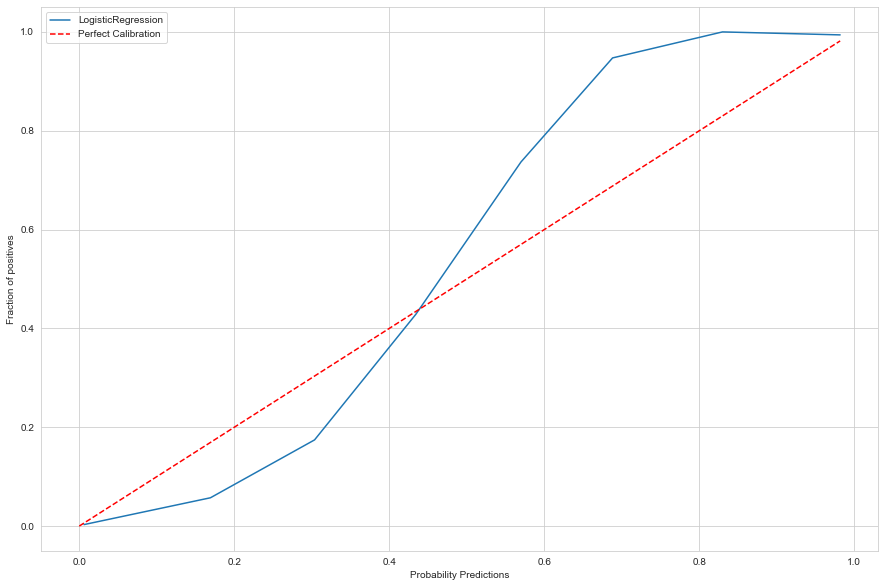

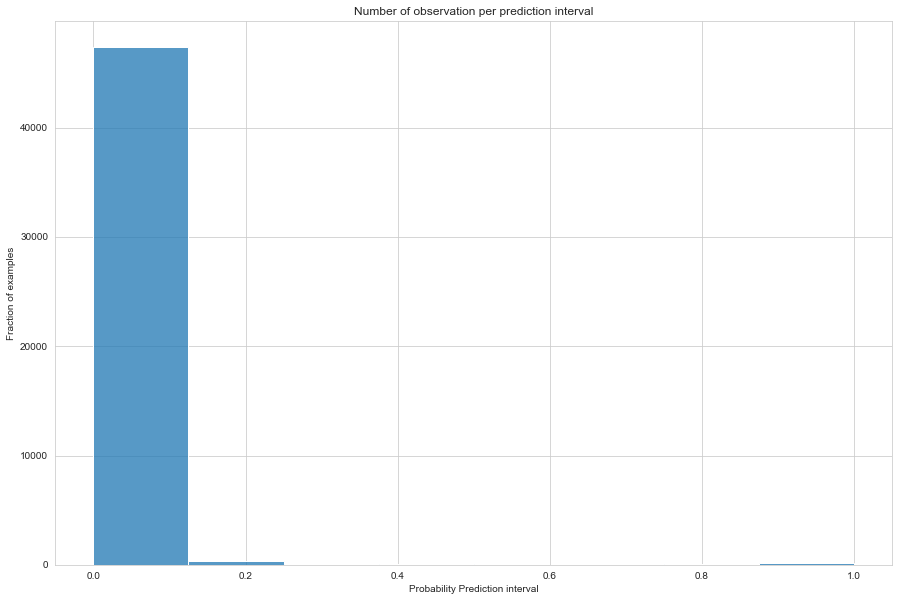

In [91]:
plot_calibration_curve(y_test, probs_lr, bins=8,
                       strategy="uniform", model="LogisticRegression")

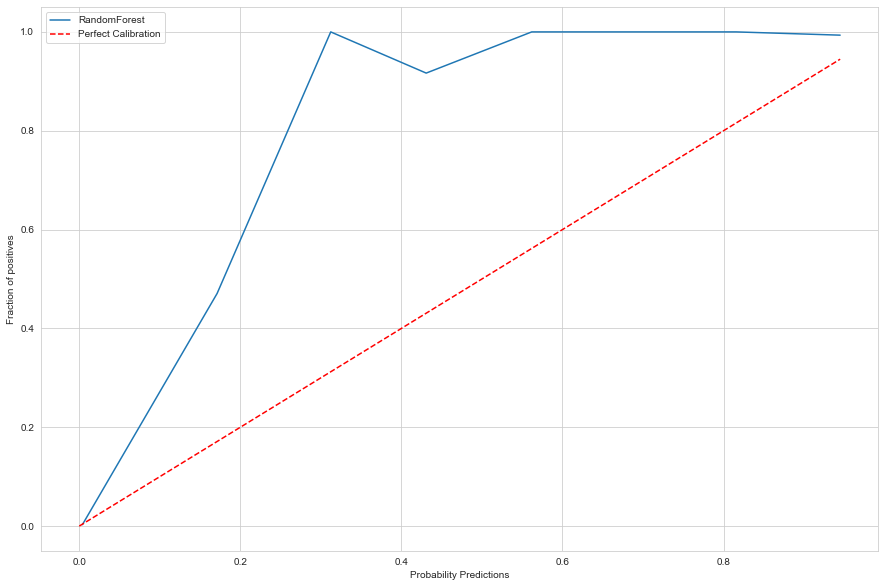

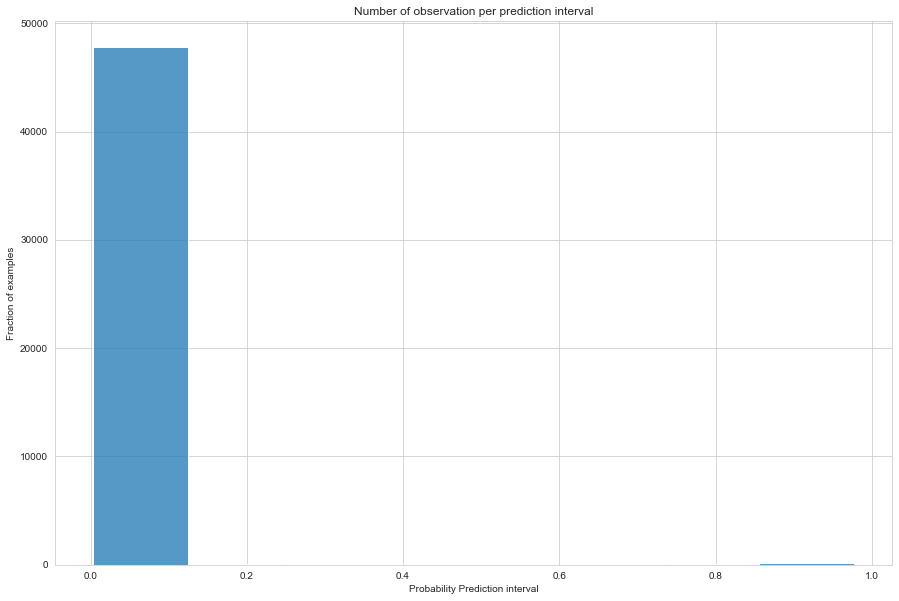

In [92]:
plot_calibration_curve(y_test,probs_rf,bins=8, strategy="uniform", model="RandomForest")

In [93]:
lr.fit(X_rus, y_rus)
probs_lr_under = lr.predict_proba(X_test)[:, 1]

rf.fit(X_rus, y_rus)
probs_rf_under = rf.predict_proba(X_test)[:, 1]

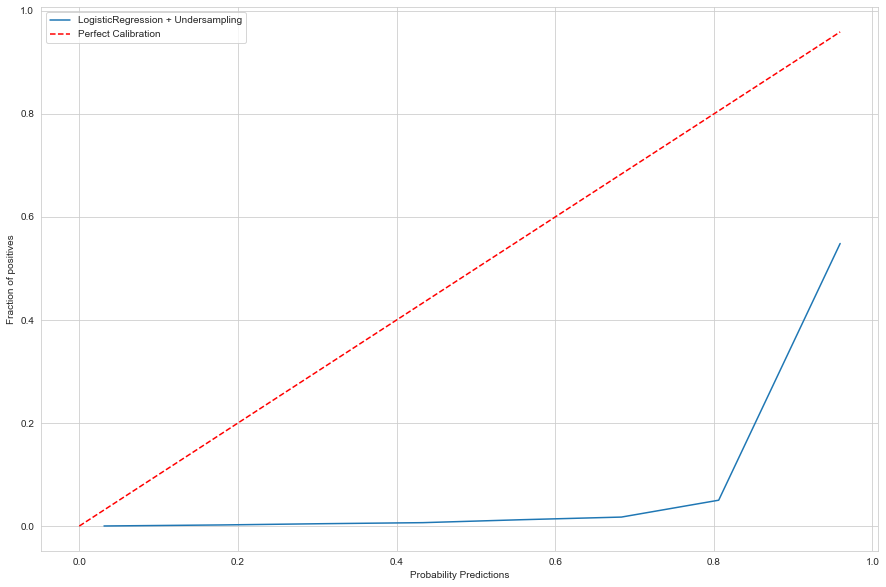

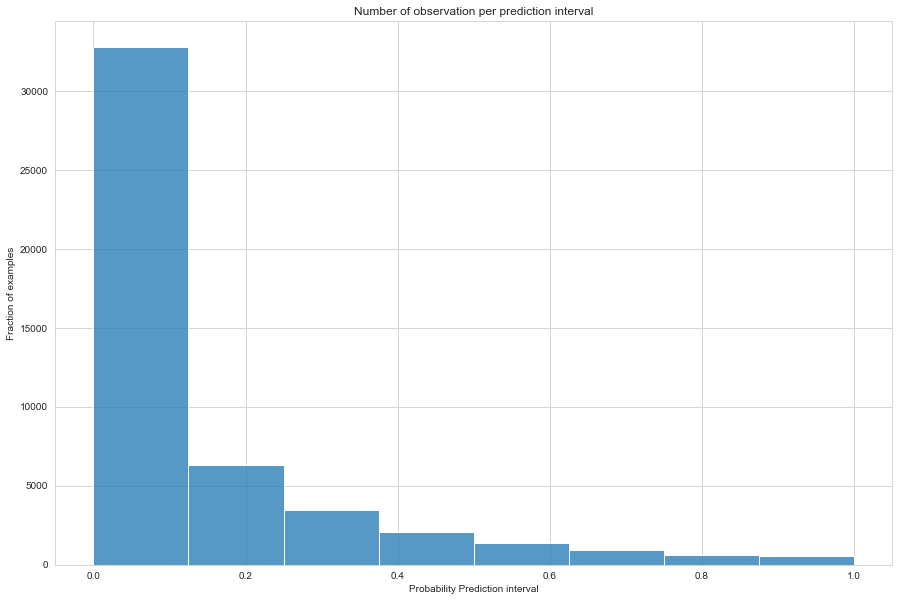

In [94]:
plot_calibration_curve(y_test,probs_lr_under,bins=8, strategy="uniform", model="LogisticRegression + Undersampling")

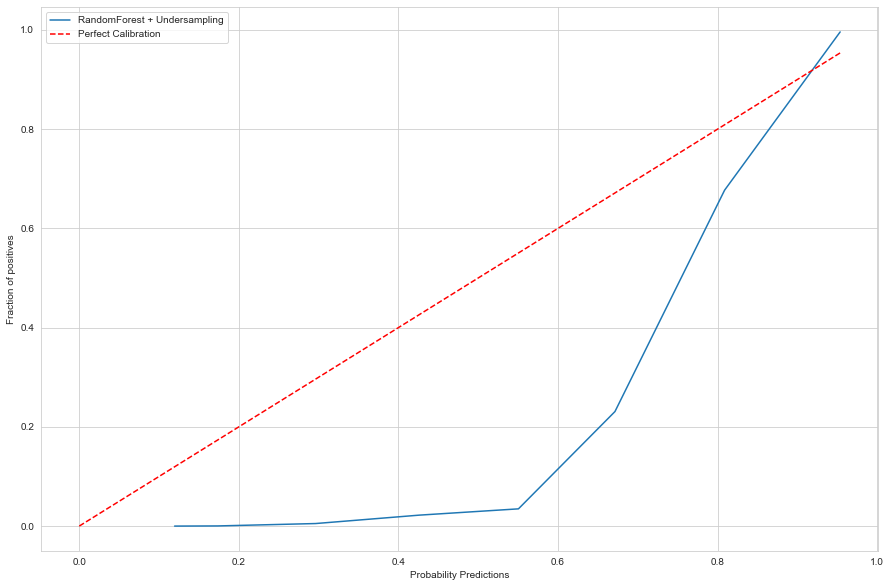

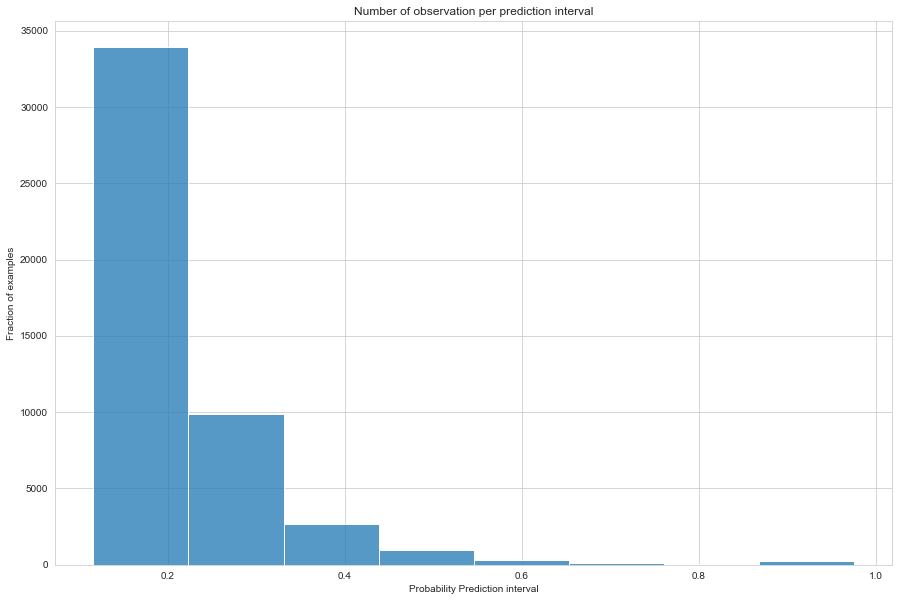

In [95]:
plot_calibration_curve(y_test,probs_rf_under,bins=8, strategy="uniform", model="RandomForest + Undersampling")

In [96]:
lr.fit(X_smb, y_smb)
probs_lr_over = lr.predict_proba(X_test)[:, 1]

rf.fit(X_smb, y_smb)
probs_rf_over = rf.predict_proba(X_test)[:, 1]

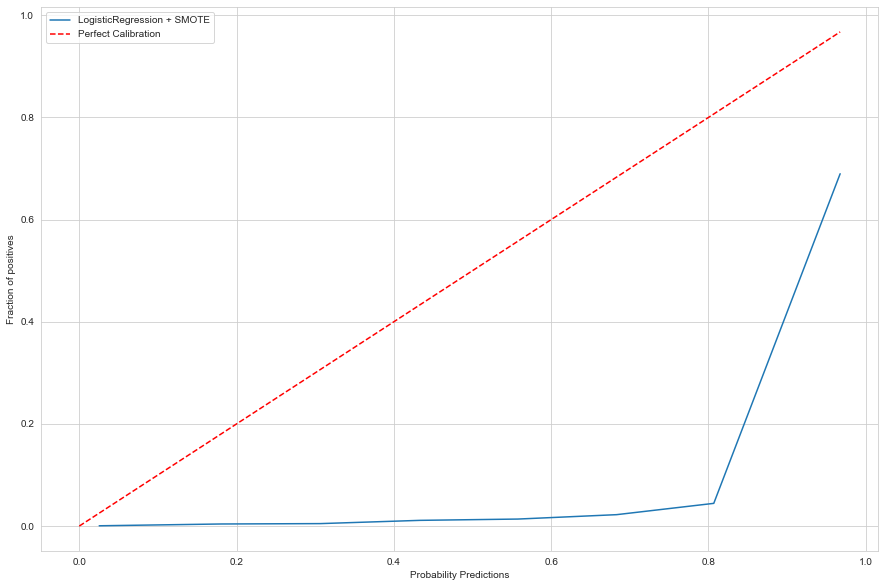

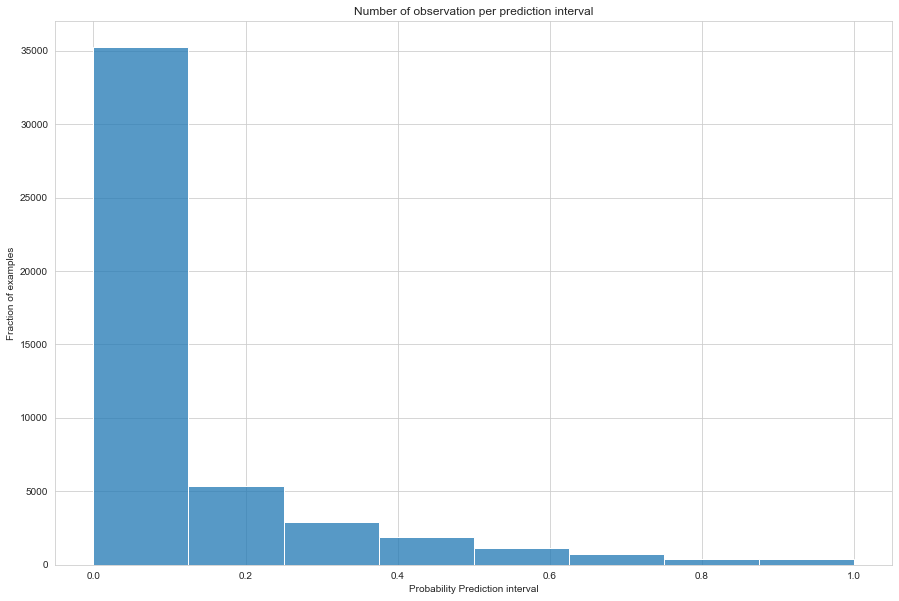

In [97]:
plot_calibration_curve(y_test,probs_lr_over,bins=8, strategy="uniform", model="LogisticRegression + SMOTE")

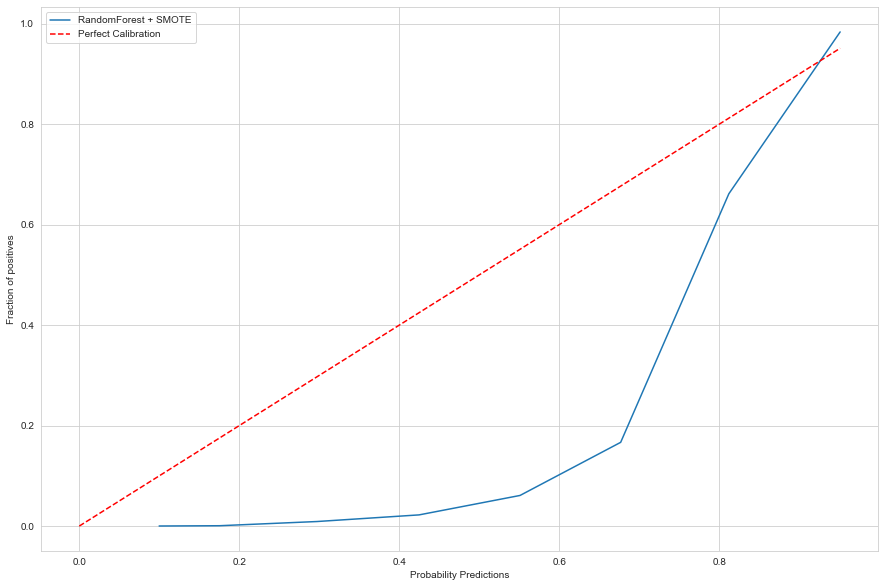

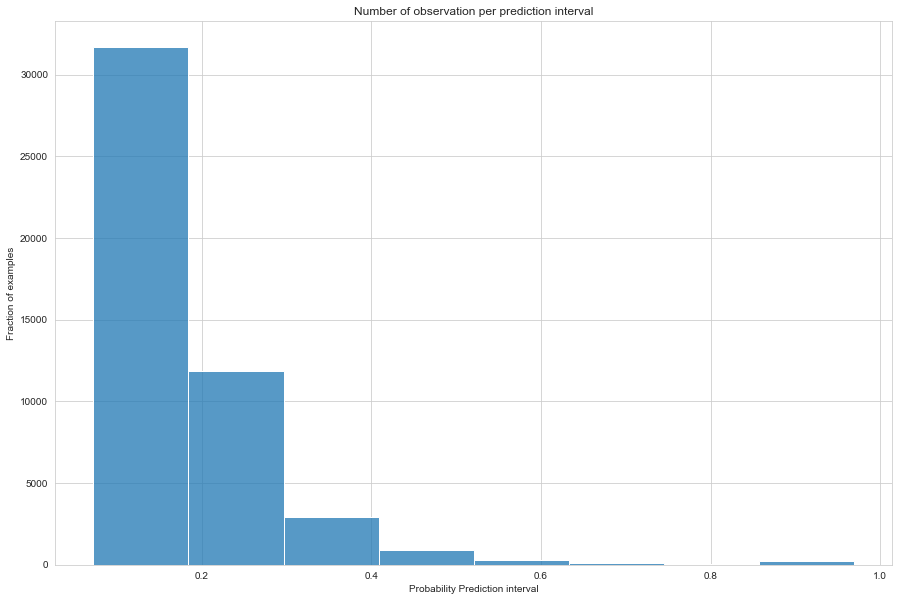

In [98]:
plot_calibration_curve(y_test,probs_rf_over,bins=8, strategy="uniform", model="RandomForest + SMOTE")

In [99]:
# Isotonic calibration
lr.fit(X_rus,y_rus)
clf_isotonic_lr = CalibratedClassifierCV(lr,cv=5,method="isotonic")
clf_isotonic_lr.fit(X_test,y_test)
prob_isotonic_lr = clf_isotonic_lr.predict_proba(X_test)[:,1]

rf.fit(X_rus,y_rus)
clf_isotonic_rf = CalibratedClassifierCV(rf,cv=5,method="isotonic")
clf_isotonic_rf.fit(X_test,y_test)
prob_isotonic_rf = clf_isotonic_rf.predict_proba(X_test)[:,1]

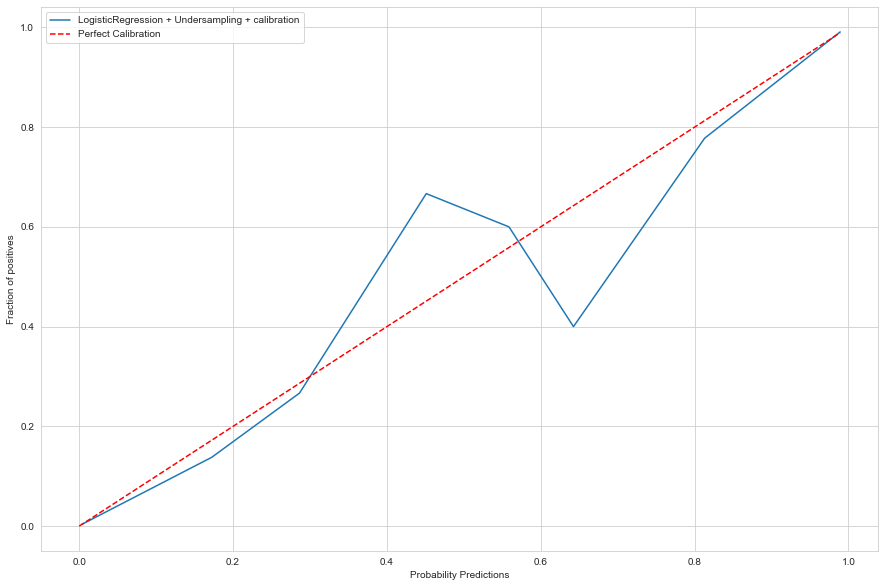

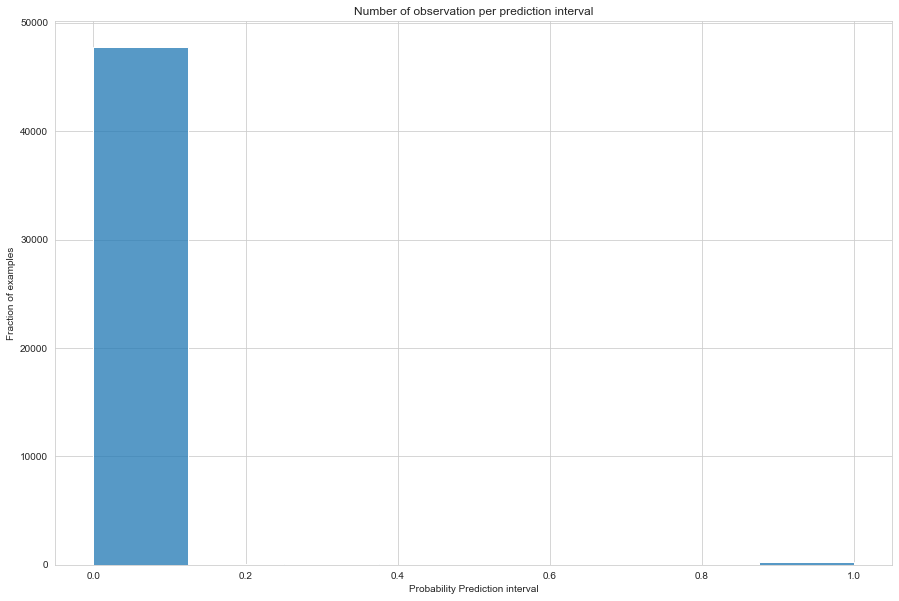

In [100]:
plot_calibration_curve(y_test,prob_isotonic_lr,bins=8, strategy="uniform", model="LogisticRegression + Undersampling + calibration")

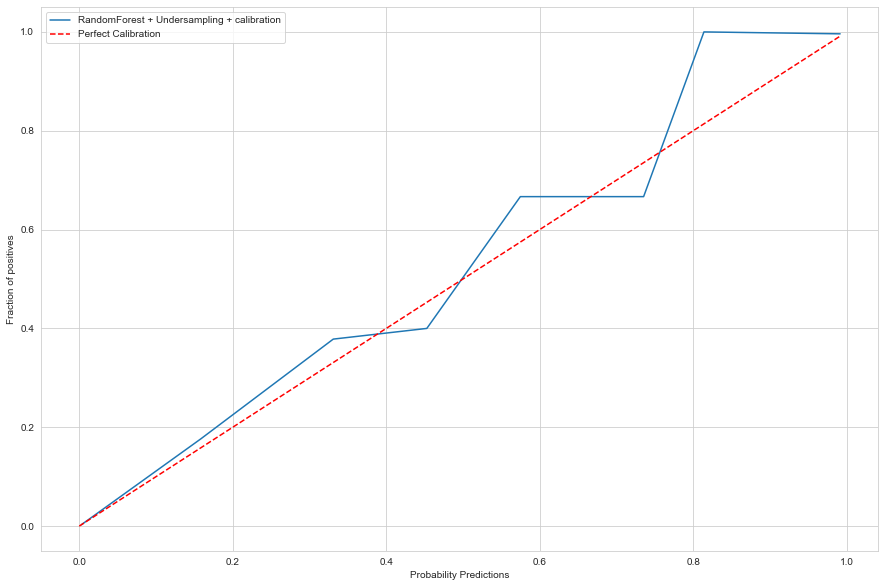

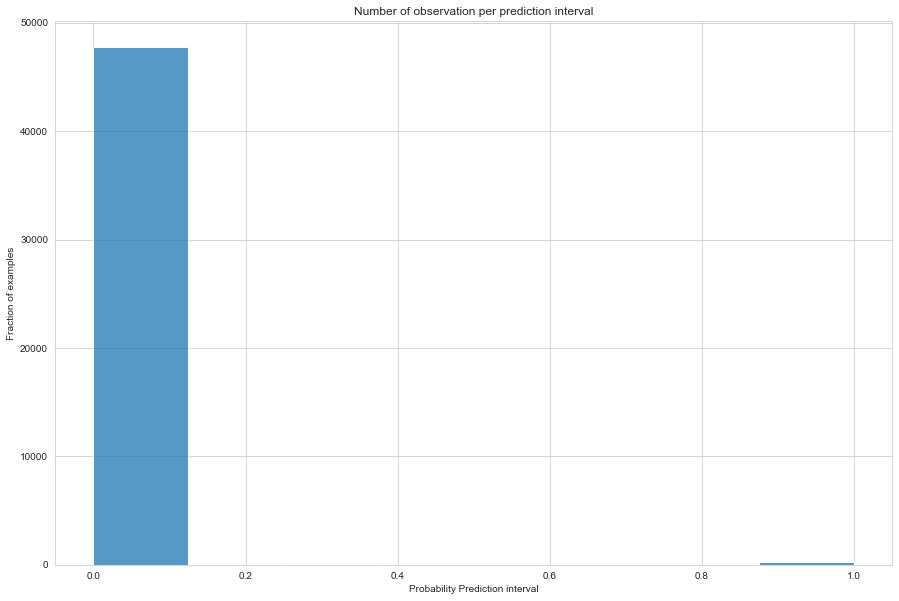

In [101]:
plot_calibration_curve(y_test,prob_isotonic_rf,bins=8, strategy="uniform", model="RandomForest + Undersampling + calibration")

In [102]:
# Isotonic calibration
lr.fit(X_smb,y_smb)
clf_isotonic_lr = CalibratedClassifierCV(lr,cv=5,method="isotonic")
clf_isotonic_lr.fit(X_test,y_test)
prob_isotonic_lr = clf_isotonic_lr.predict_proba(X_test)[:,1]

rf.fit(X_smb,y_smb)
clf_isotonic_rf = CalibratedClassifierCV(rf,cv=5,method="isotonic")
clf_isotonic_rf.fit(X_test,y_test)
prob_isotonic_rf = clf_isotonic_rf.predict_proba(X_test)[:,1]

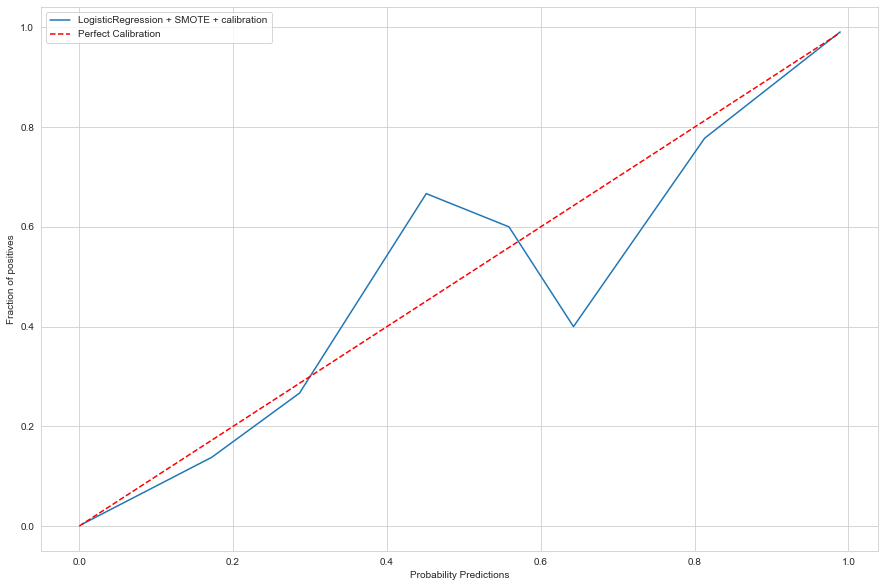

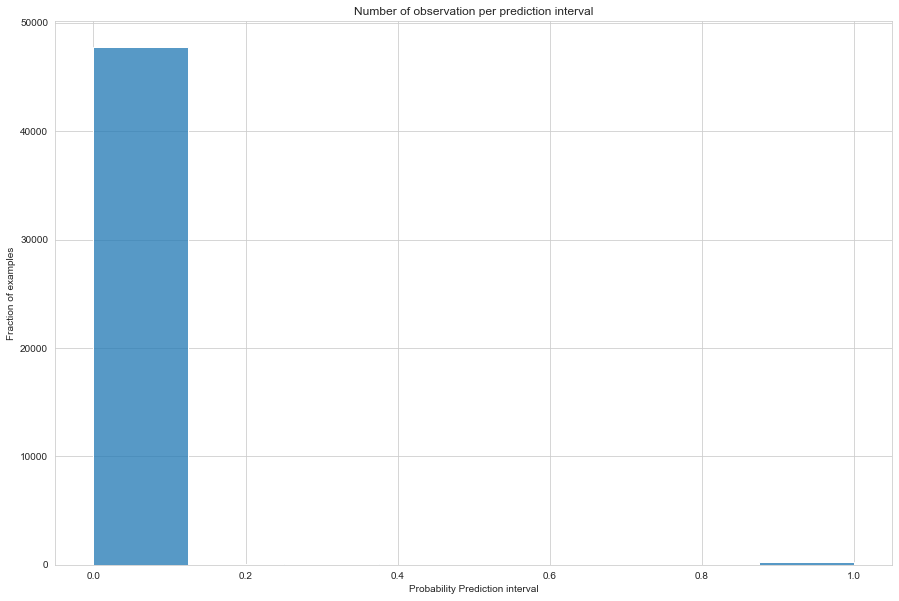

In [103]:
plot_calibration_curve(y_test,prob_isotonic_lr,bins=8, strategy="uniform", model="LogisticRegression + SMOTE + calibration")

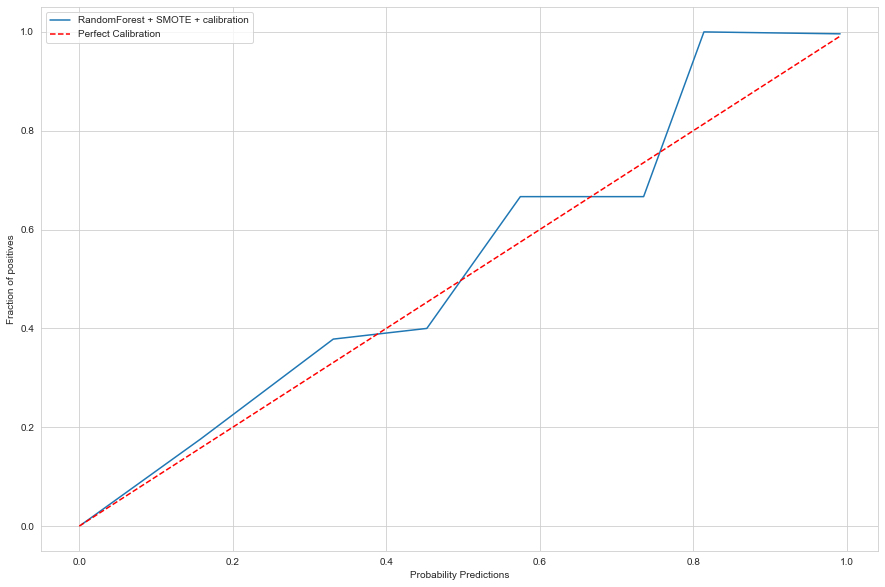

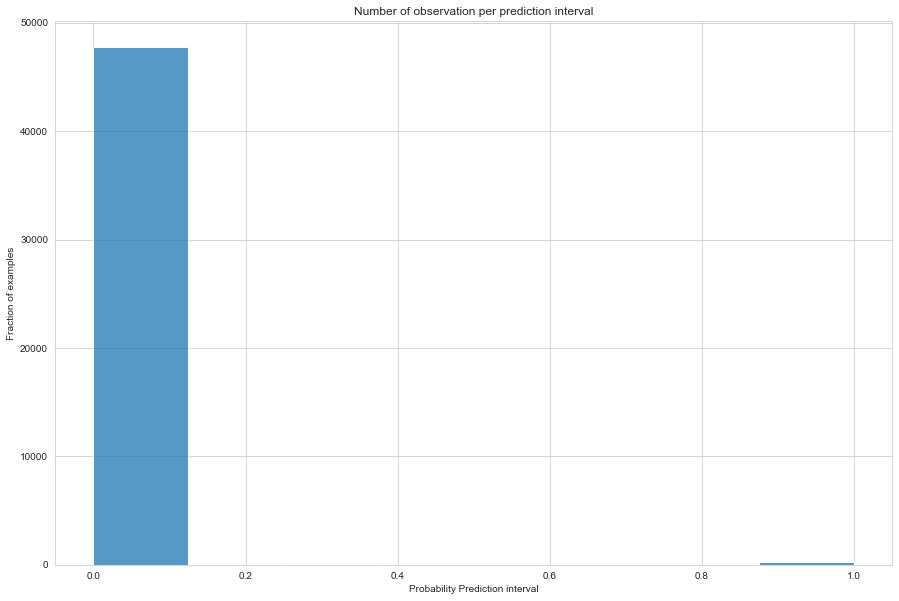

In [104]:
plot_calibration_curve(y_test,prob_isotonic_rf,bins=8, strategy="uniform", model="RandomForest + SMOTE + calibration")

The probabilities have been recalibrated!

# Calibrating a Classifier with Cost-Sensitive Learning

In [105]:
df = load_data()

In [106]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(
    labels=["target"], axis=1), df["target"], test_size=0.33, random_state=24)

In [107]:
y_train.value_counts(normalize=True)

0    0.991019
1    0.008981
Name: target, dtype: float64

In [108]:
rf_cs = RandomForestClassifier(n_estimators=100,
                            random_state=24,
                            max_depth=2,
                            class_weight="balanced",
                            n_jobs=-1).fit(X_train,y_train)

lr_cs = LogisticRegression(penalty="l2",
                        solver="newton-cg",
                        random_state=24,
                        max_iter=10,
                        class_weight="balanced",
                        n_jobs=-1).fit(X_train,y_train)

Baseline Model
Roc-auc on test set for RandomForestClassifier: 0.9717603317852419
Brier Score on test set for RandomForestClassifier: 0.03866445217299514




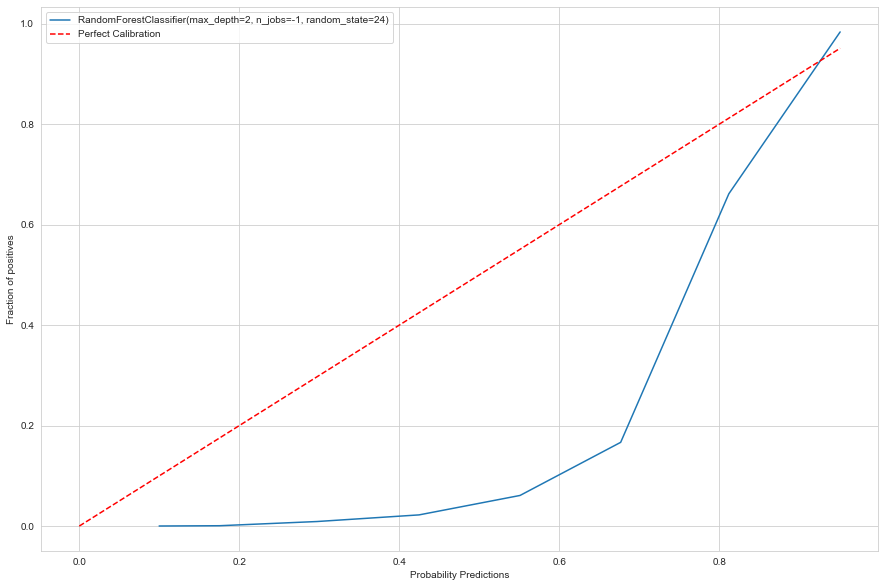

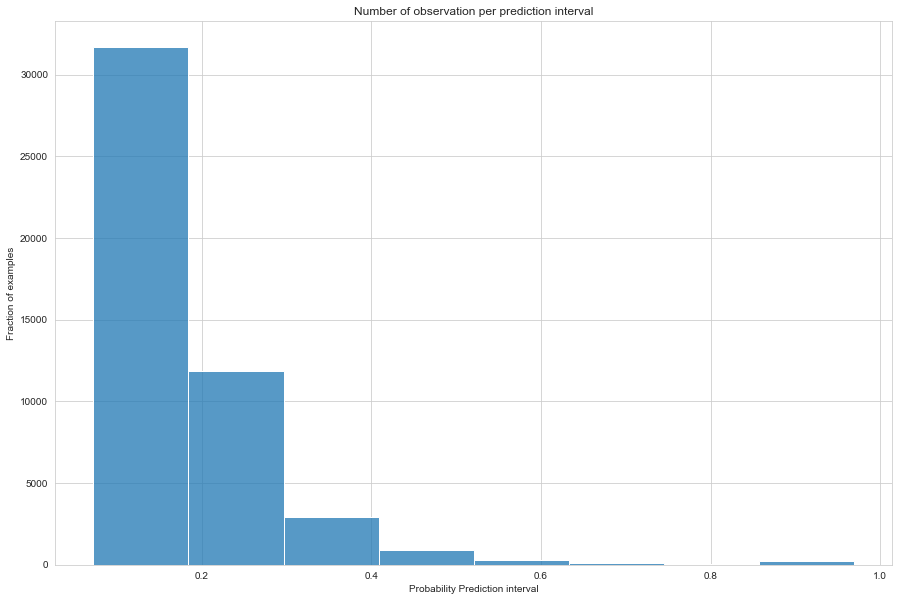

Baseline Model
Roc-auc on test set for LogisticRegression: 0.9567483440496387
Brier Score on test set for LogisticRegression: 0.04147959499382138




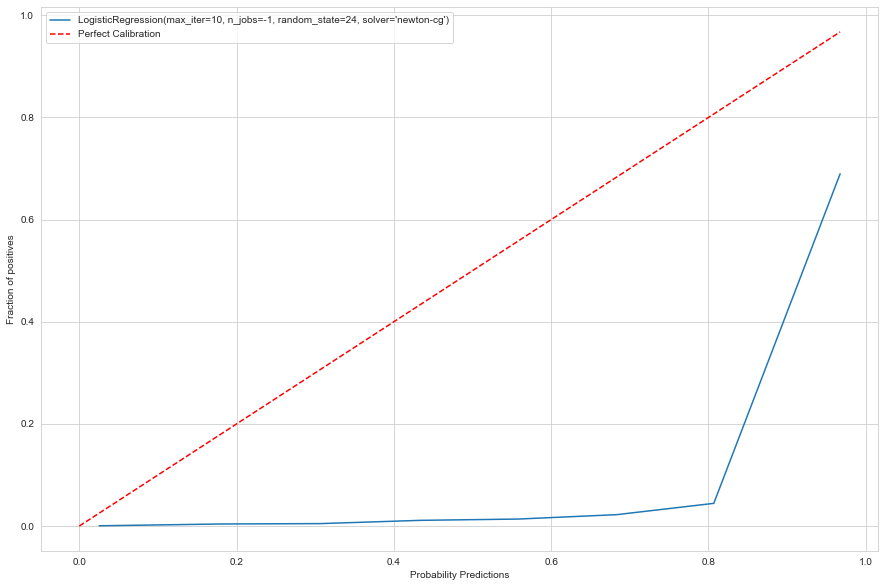

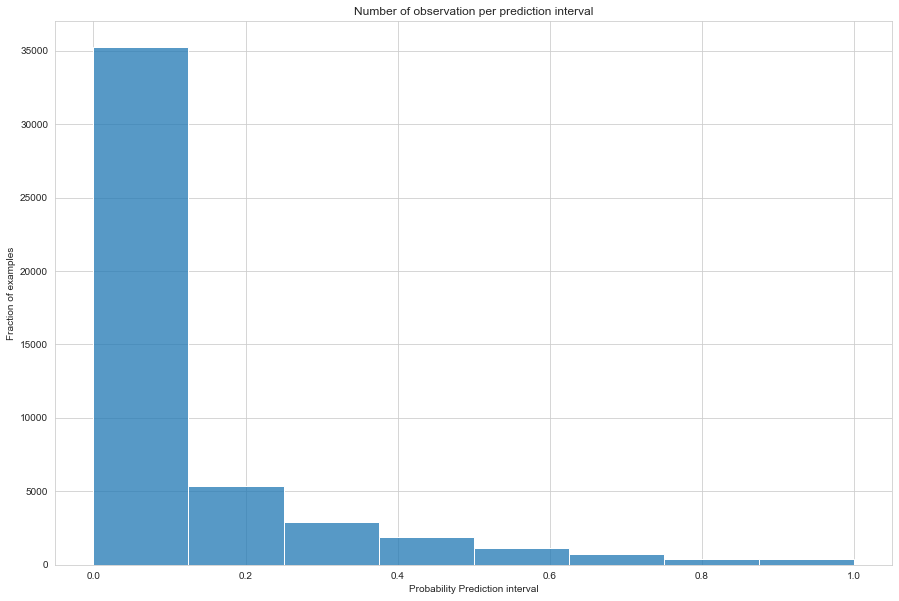

Baseline Model
Roc-auc on test set for RandomForestClassifier: 0.9775699923629086
Brier Score on test set for RandomForestClassifier: 0.04665927673569135




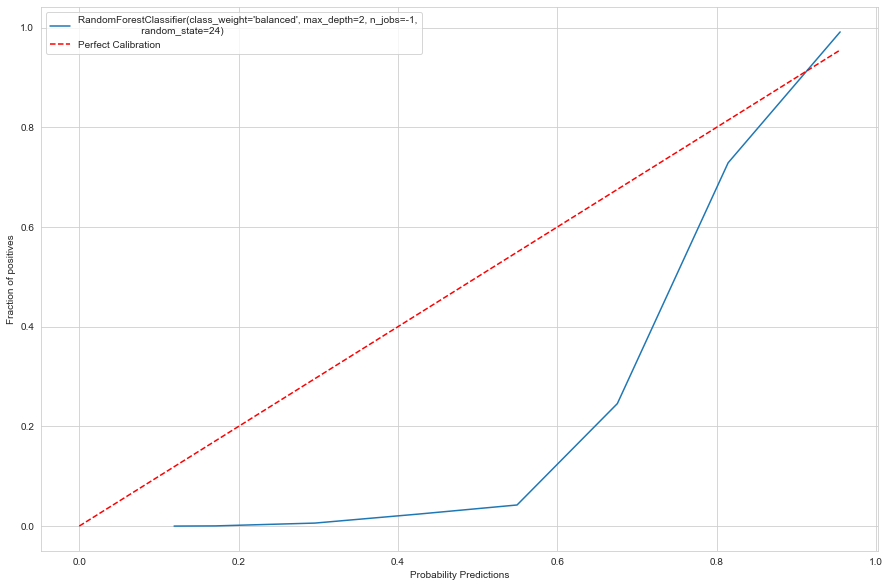

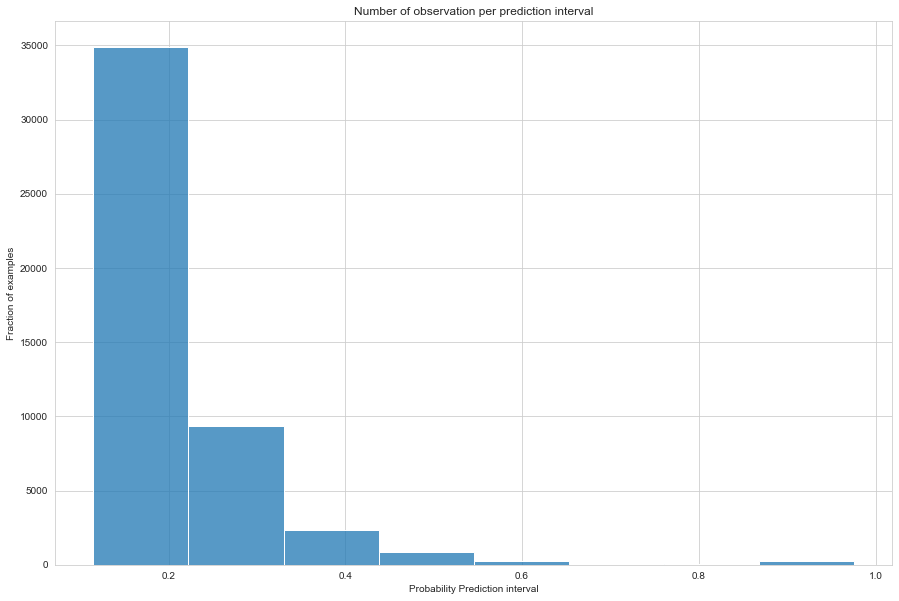

Baseline Model
Roc-auc on test set for LogisticRegression: 0.9667857356132781
Brier Score on test set for LogisticRegression: 0.05171298192472734




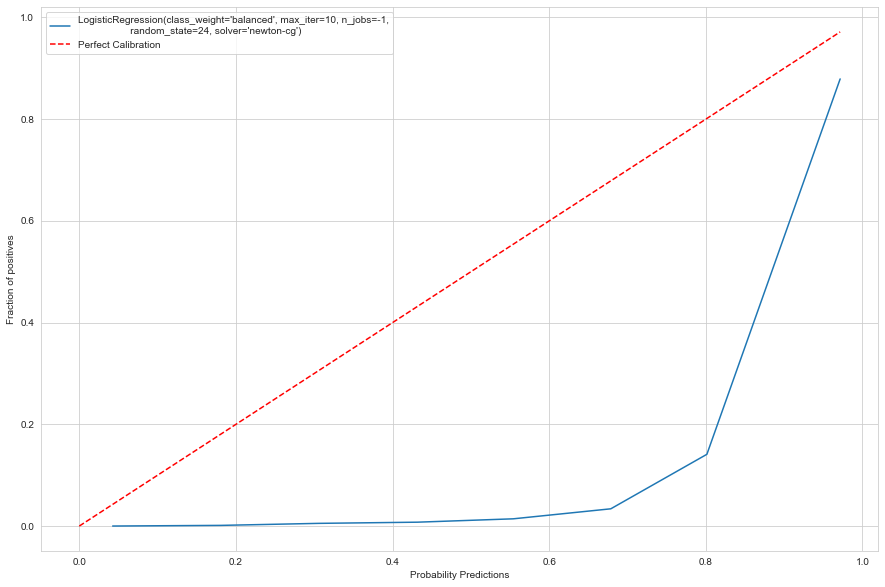

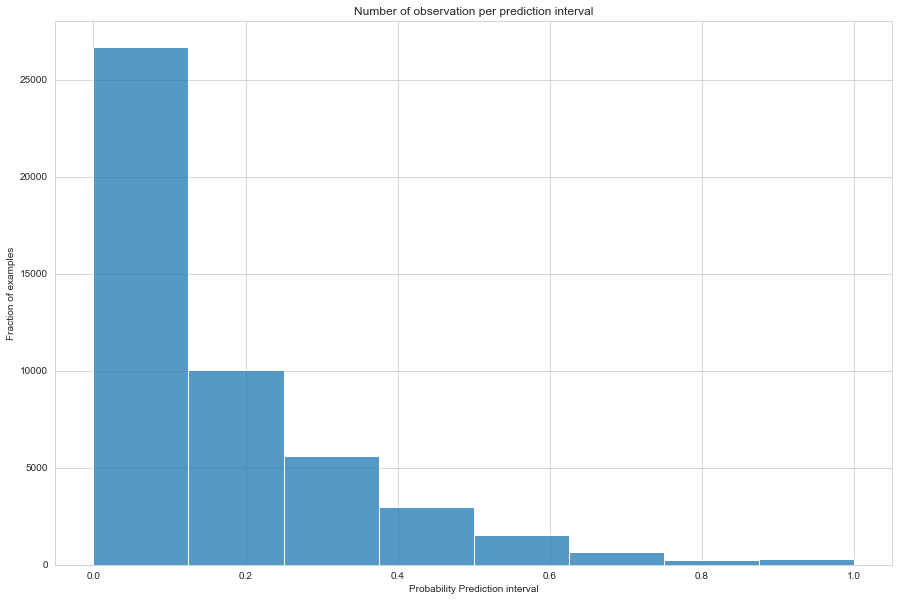

In [109]:
for model in [rf, lr,rf_cs,lr_cs]:
    print("Baseline Model")
    probs = model.predict_proba(X_test)[:, 1]
    print(f"Roc-auc on test set for {type(model).__name__}: {roc_auc_score(y_test,probs)}")
    print(f"Brier Score on test set for {type(model).__name__}: {brier_score_loss(y_test,probs)}")
    print("\n")
    plot_calibration_curve(y_test,probs,bins=8, strategy="uniform", model=model)

In [110]:
# Isotonic calibration
lr_cs.fit(X_train,y_train)
clf_isotonic_lr = CalibratedClassifierCV(lr_cs,cv=5,method="isotonic")
clf_isotonic_lr.fit(X_test,y_test)
prob_isotonic_lr = clf_isotonic_lr.predict_proba(X_test)[:,1]

rf_cs.fit(X_train,y_train)
clf_isotonic_rf = CalibratedClassifierCV(rf_cs,cv=5,method="isotonic")
clf_isotonic_rf.fit(X_test,y_test)
prob_isotonic_rf = clf_isotonic_rf.predict_proba(X_test)[:,1]

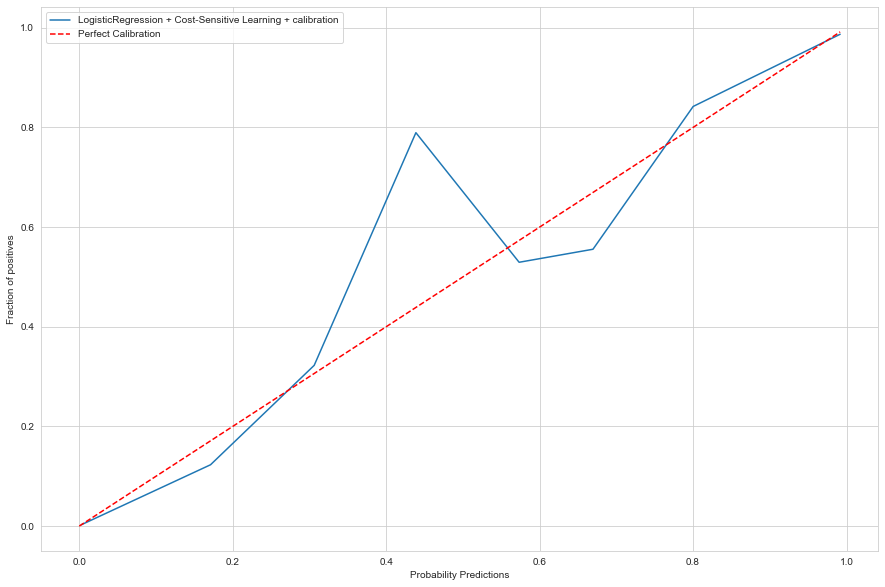

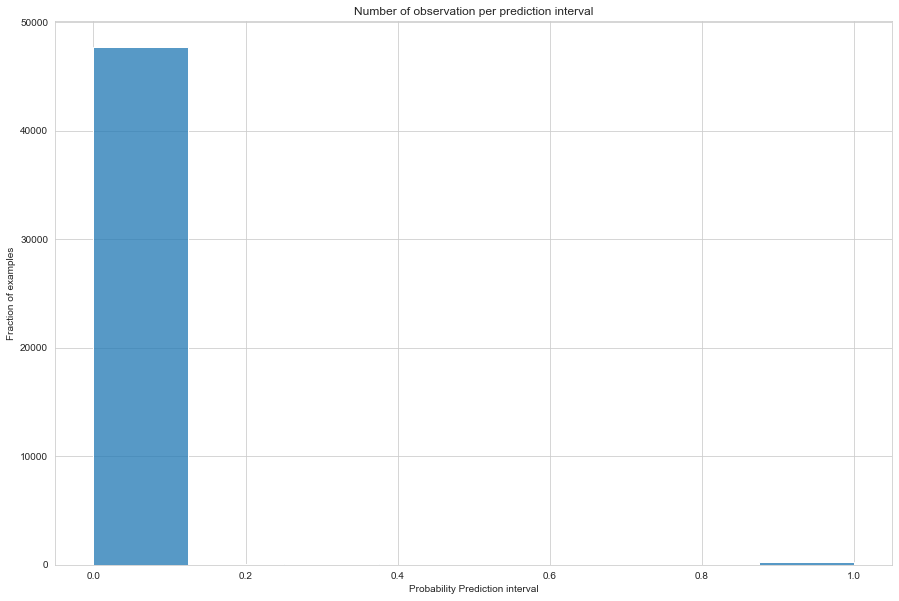

In [111]:
plot_calibration_curve(y_test,prob_isotonic_lr,bins=8, strategy="uniform", model="LogisticRegression + Cost-Sensitive Learning + calibration")

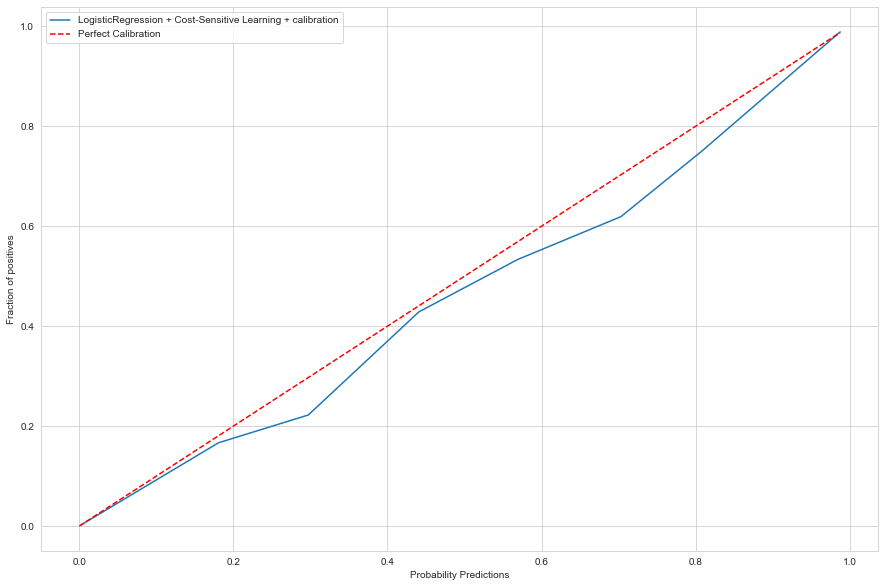

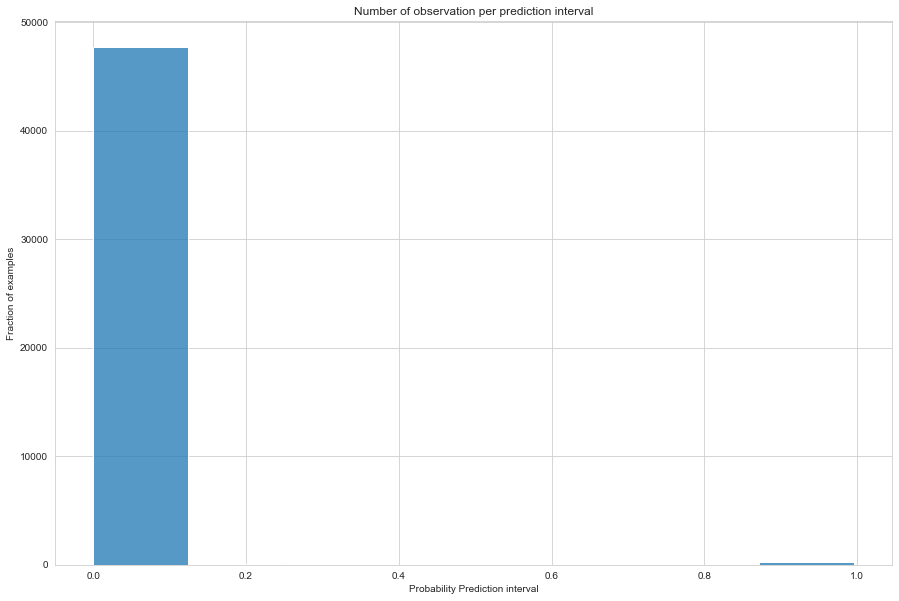

In [112]:
plot_calibration_curve(y_test,prob_isotonic_rf,bins=8, strategy="uniform", model="LogisticRegression + Cost-Sensitive Learning + calibration")

The probabilities have been recalibrated!